# EDA for MetMCC-SCAN (SEER database)

### Yanrong (Jerry) Ji

In [4]:
%matplotlib inline

In [5]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [6]:
BASE_DIR = os.path.dirname(os.path.realpath('EDA')) + '/'

In [7]:
# read in data
mcc_seer = pd.read_csv(BASE_DIR + '../data/MerkelAllVarSEER_RT.csv')

In [8]:
mcc_seer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9280 entries, 0 to 9279
Columns: 179 entries, Age recode with <1 year olds to Rural-Urban Continuum Code
dtypes: int64(179)
memory usage: 12.7 MB


In [9]:
mcc_seer.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,PRCDA 2017,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Site recode ICD-O-3/WHO 2008,Behavior recode for analysis,AYA site recode/WHO 2008,...,Site - mal+ins (least detail),SS seq # - mal (least detail),SS seq # 1975+ - mal (least detail),SS seq # 1992+ - mal (least detail),SS seq # 2000+ - mal (least detail),Site - malignant (least detail),Patient ID,Type of Reporting Source,Median household income inflation adj to 2018,Rural-Urban Continuum Code
0,11,1,217,0,1,0,1,45,3,30,...,17,1,1,1,1,17,4003,1,10,1
1,14,1,204,0,1,0,1,45,3,30,...,17,1,1,1,1,17,4703,1,10,1
2,16,1,205,0,1,0,1,45,3,30,...,17,1,1,1,1,17,4723,1,10,1
3,18,2,215,0,1,0,1,45,3,30,...,17,1,1,1,1,17,5331,1,10,1
4,17,1,205,0,1,0,1,45,3,30,...,17,1,1,1,1,17,5567,1,10,1


In [10]:
mcc_seer.shape

(9280, 179)

In [12]:
for col in mcc_seer.columns:
    print(col)

Age recode with <1 year olds
Sex
Year of diagnosis
PRCDA 2017
Race recode (W, B, AI, API)
Origin recode NHIA (Hispanic, Non-Hisp)
Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)
Site recode ICD-O-3/WHO 2008
Behavior recode for analysis
AYA site recode/WHO 2008
Lymphoma subtype recode/WHO 2008
ICCC site recode 3rd edition/IARC 2017
TNM 7/CS v0204+ Schema
CS Schema - AJCC 6th Edition
Primary Site - labeled
Primary Site
Histologic Type ICD-O-3
Behavior code ICD-O-3
Grade
Laterality
Diagnostic Confirmation
ICD-O-3 Hist/behav
ICD-O-3 Hist/behav, malignant
Histology recode - broad groupings
Histology recode - Brain groupings
ICCC site recode extended 3rd edition/IARC 2017
Site recode B ICD-O-3/WHO 2008
ICCC site recode ICD-O-3/WHO 2008
ICCC site rec extended ICD-O-3/WHO 2008
Summary stage 2000 (1998+)
SEER Combined Summary Stage 2000 (2004+)
SEER historic stage A (1973-2015)
Derived AJCC Stage Group, 7th ed (2010-2015)
Derived AJCC T, 7th ed (2010-2015)
Derived AJCC N, 7th ed (201

## Things to do (will keep track here)
- missing value 
>- leave as it is (treating as additional category, to allow user input blank but still make prediction) 
>- impute
- SLNB positive (response) agrees with others (e.g. REGIONAL_NODES_POSITIVE)
- convert coding to categorical
- distributions
- correlations
- relationship with outcome


## First focus on seer

## Labels in seer

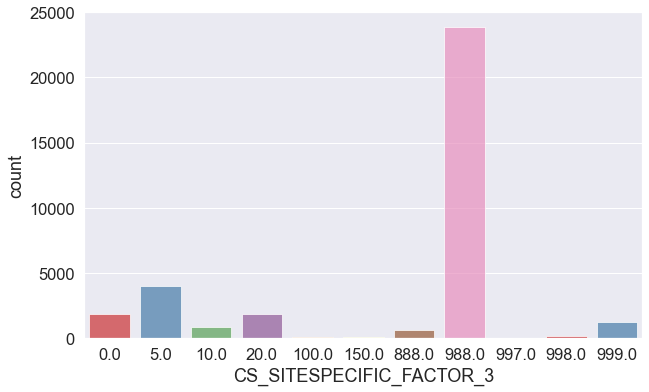

6736


In [16]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="CS_SITESPECIFIC_FACTOR_3", data=mcc_seer, palette="Set1", alpha=.7)
plt.show()
print(len(mcc_seer[mcc_seer['CS_SITESPECIFIC_FACTOR_3'] < 20]))

label > 100 = Not available

In [20]:
# only keep those that are coded 000, 005 and 010
mcc_seer_new = mcc_seer[mcc_seer['CS_SITESPECIFIC_FACTOR_3'] < 20].replace([0.0,5.0,10.0],[0,0,1])
# also filter by histology and only keep 8247
mcc_seer_new = mcc_seer_new[mcc_seer_new['HISTOLOGY'] == 8247]
target = mcc_seer_new.loc[:, 'CS_SITESPECIFIC_FACTOR_3']
mcc_seer_new.drop(['PUF_CASE_ID','PUF_FACILITY_ID',
                   'FACILITY_TYPE_CD','FACILITY_LOCATION_CD',
#                    'CS_SITESPECIFIC_FACTOR_3'
                  ], axis=1, inplace=True)

In [21]:
mcc_seer_new.head()

,AGE,SEX,RACE,SPANISH_HISPANIC_ORIGIN,INSURANCE_STATUS,MED_INC_QUAR_00,NO_HSD_QUAR_00,UR_CD_03,MED_INC_QUAR_12,NO_HSD_QUAR_12,...,RX_HOSP_SURG_PRIM_SITE,RX_HOSP_CHEMO,RX_HOSP_IMMUNOTHERAPY,RX_HOSP_HORMONE,RX_HOSP_OTHER,PUF_MULT_SOURCE,PUF_REFERENCE_DATE_FLAG,RX_SUMM_SCOPE_REG_LN_2012,RX_HOSP_DXSTG_PROC,PALLIATIVE_CARE_HOSP
8,71,1,1,0,1,3.0,2.0,6.0,2.0,2.0,...,27,0,0,0,0,0,1,NaN,0,0
14,43,1,1,0,1,4.0,4.0,1.0,4.0,4.0,...,0,0,0,0,0,1,1,2.0,0,0
19,59,2,1,0,1,4.0,3.0,1.0,4.0,2.0,...,0,0,0,0,0,1,1,4.0,0,0
23,82,2,1,0,3,4.0,4.0,1.0,4.0,3.0,...,30,0,0,0,0,0,1,0.0,0,0
31,90,1,1,0,3,3.0,2.0,1.0,3.0,3.0,...,0,0,0,0,0,1,1,2.0,0,0


In [23]:
# check out which features are not numerically coded
mcc_seer_new.apply(lambda x: print(x.name,' ',x.dtype))
nonnumeric_features = ['PRIMARY_SITE', 'TNM_CLIN_T',
                       'TNM_CLIN_N', 'TNM_CLIN_M',
                       'TNM_CLIN_STAGE_GROUP',
                       'TNM_PATH_T','TNM_PATH_N',
                       'TNM_PATH_M','TNM_PATH_STAGE_GROUP'
                      ]

AGE   int64
SEX   int64
RACE   int64
SPANISH_HISPANIC_ORIGIN   int64
INSURANCE_STATUS   int64
MED_INC_QUAR_00   float64
NO_HSD_QUAR_00   float64
UR_CD_03   float64
MED_INC_QUAR_12   float64
NO_HSD_QUAR_12   float64
UR_CD_13   float64
CROWFLY   float64
CDCC_TOTAL_BEST   int64
SEQUENCE_NUMBER   int64
CLASS_OF_CASE   int64
YEAR_OF_DIAGNOSIS   int64
PRIMARY_SITE   object
LATERALITY   int64
HISTOLOGY   int64
BEHAVIOR   int64
GRADE   int64
DIAGNOSTIC_CONFIRMATION   int64
TUMOR_SIZE   int64
REGIONAL_NODES_POSITIVE   int64
REGIONAL_NODES_EXAMINED   int64
DX_STAGING_PROC_DAYS   float64
RX_SUMM_DXSTG_PROC   int64
TNM_CLIN_T   object
TNM_CLIN_N   object
TNM_CLIN_M   object
TNM_CLIN_STAGE_GROUP   object
TNM_PATH_T   object
TNM_PATH_N   object
TNM_PATH_M   object
TNM_PATH_STAGE_GROUP   object
TNM_EDITION_NUMBER   int64
ANALYTIC_STAGE_GROUP   int64
CS_METS_AT_DX   int64
CS_METS_EVAL   int64
CS_EXTENSION   int64
CS_TUMOR_SIZEEXT_EVAL   int64
CS_METS_DX_BONE   float64
CS_METS_DX_BRAIN   float64
CS_MET

## First remove those with near zero variance (almost all have same value)

Goal is to have less features for EDA

In [24]:
mcc_seer_num = mcc_seer_new.loc[:, mcc_seer_new.columns.difference(nonnumeric_features)]
mcc_seer_categ = mcc_seer_new.loc[:, nonnumeric_features]

In [25]:
mcc_seer_num.var().describe()

count    1.130000e+02
mean     4.399307e+06
std      3.494009e+07
min      0.000000e+00
25%      6.096885e-01
50%      3.184707e+01
75%      3.071440e+03
max      3.379860e+08
dtype: float64

In [26]:
mcc_seer_num = mcc_seer_num.loc[:, mcc_seer_num.var() >= 0.5]

In [27]:
mcc_seer_num.shape

(6136, 90)

## Distribution (check missing values)

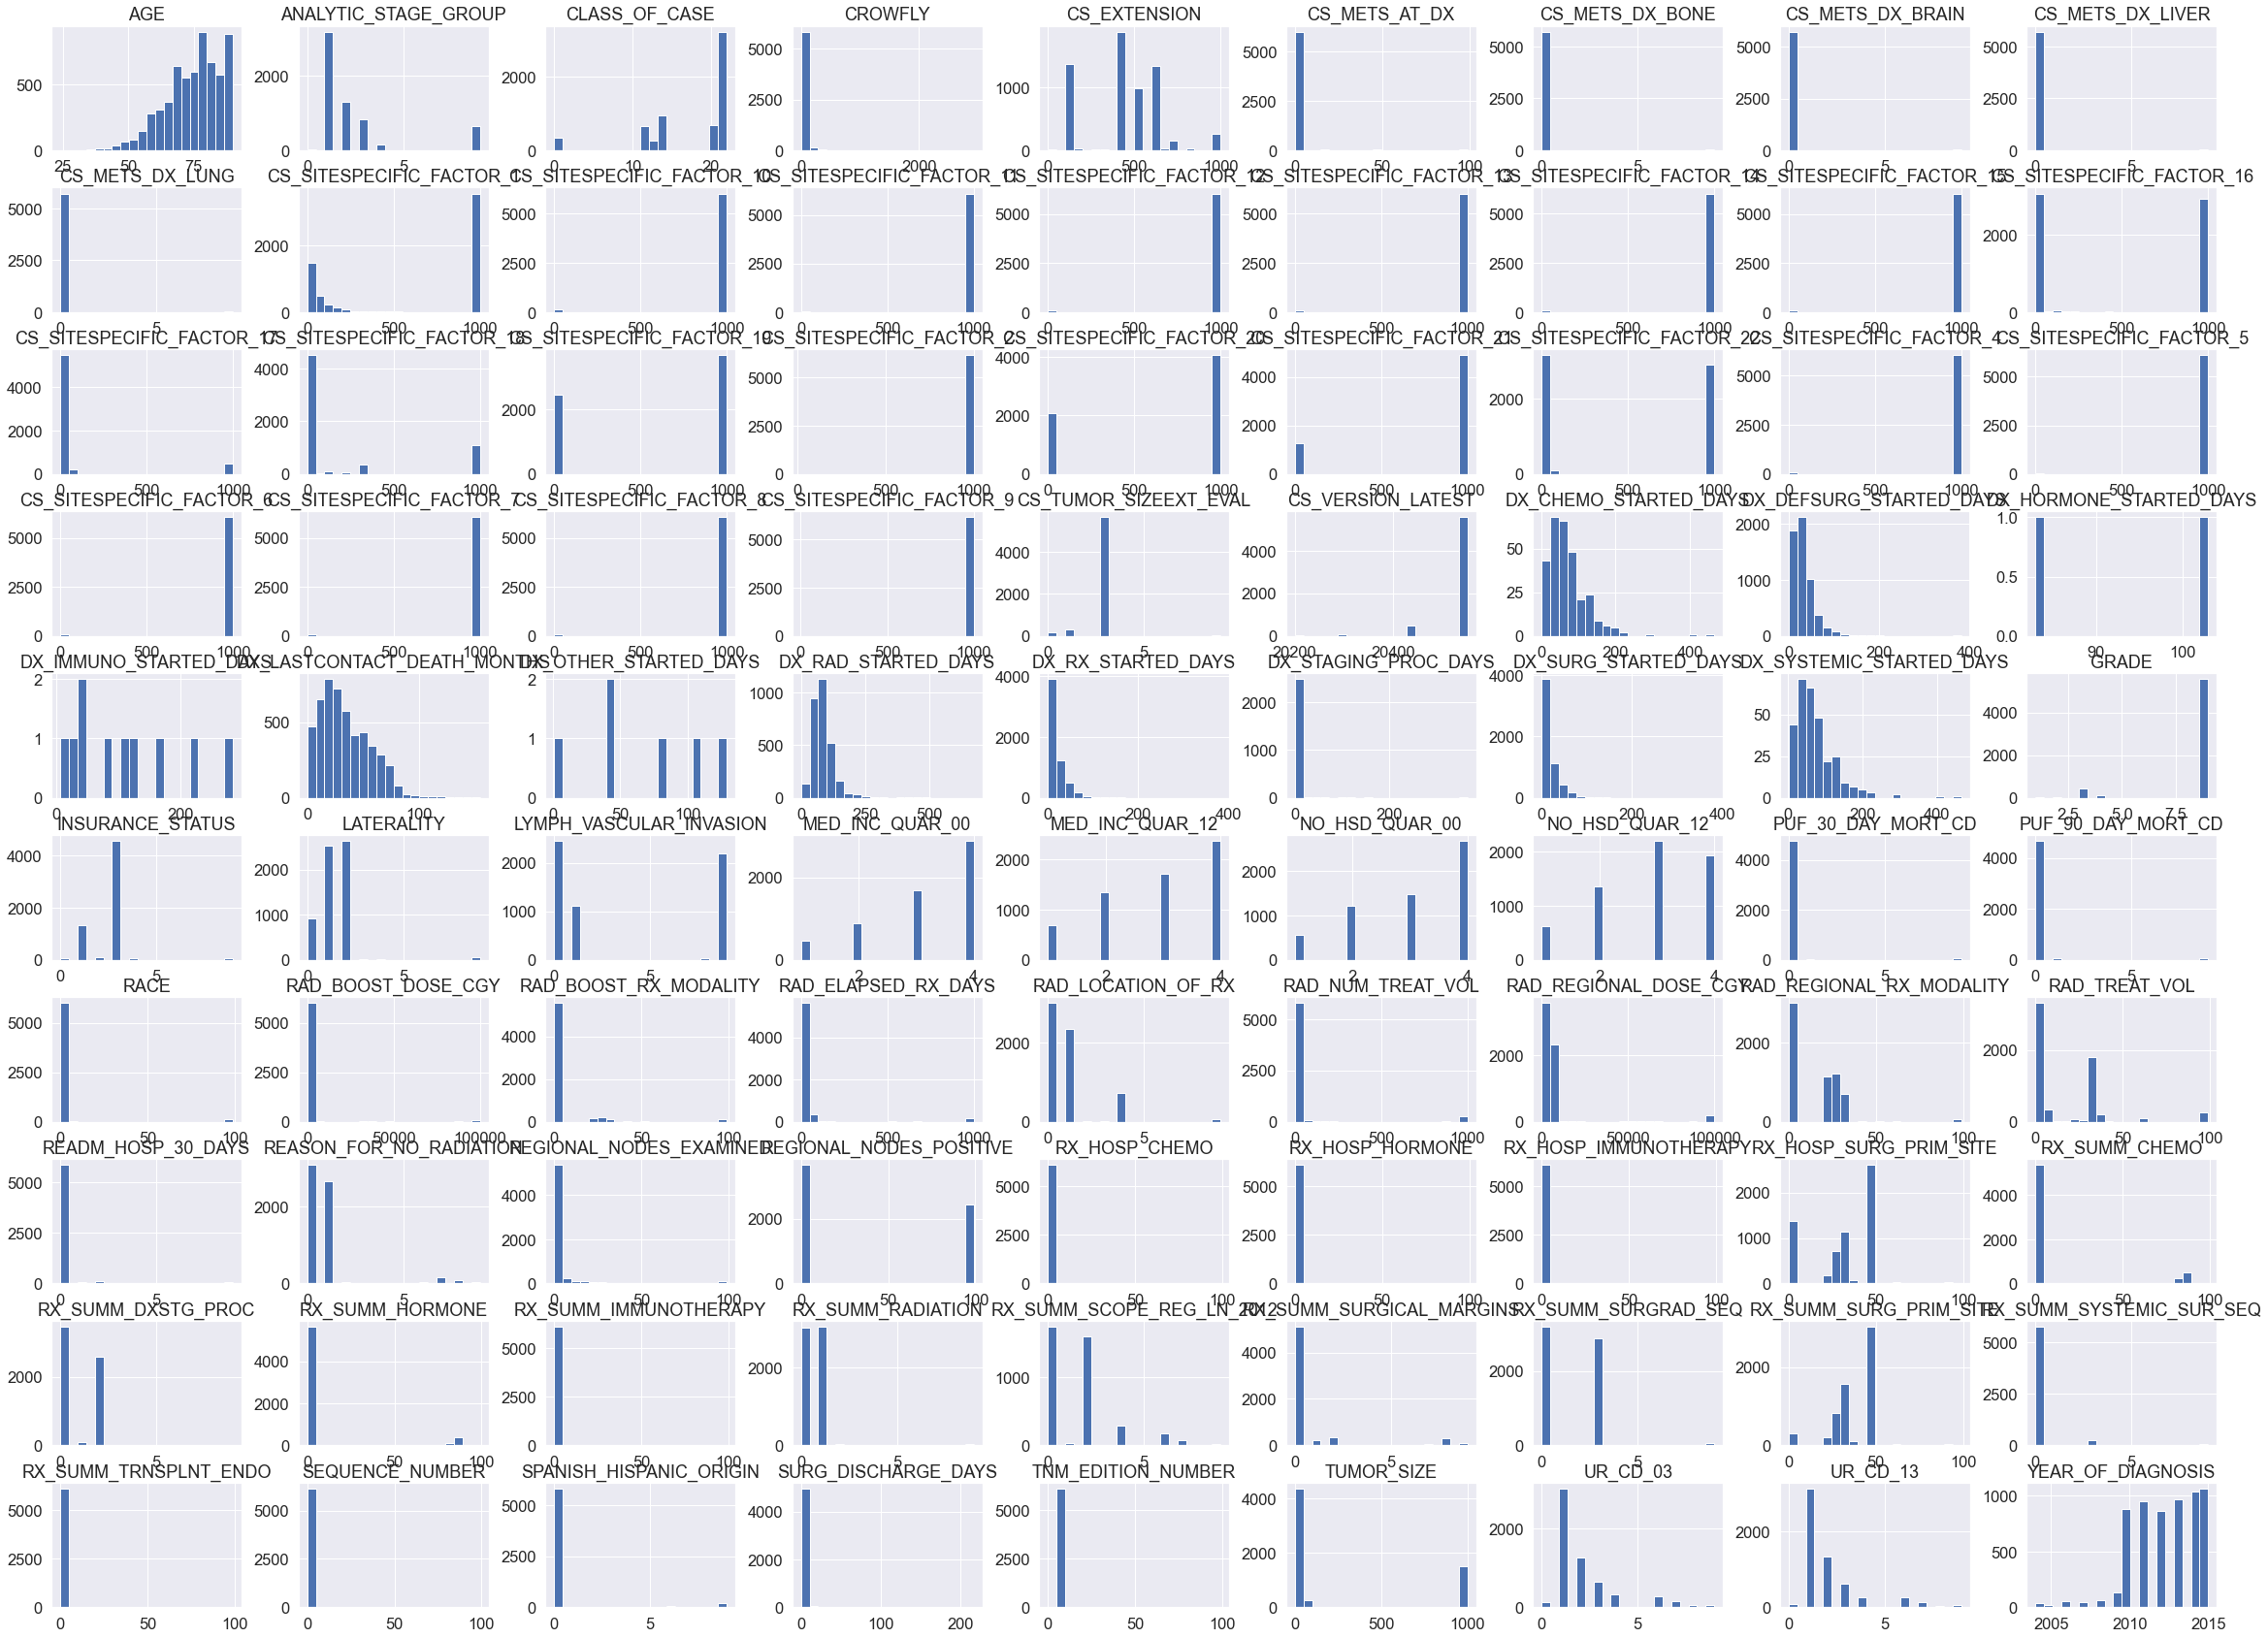

In [28]:
mcc_seer_num.hist(bins=20, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [29]:
site_specific_factors = [
             'CS_SITESPECIFIC_FACTOR_1',
             'CS_SITESPECIFIC_FACTOR_2',
             'CS_SITESPECIFIC_FACTOR_3',
             'CS_SITESPECIFIC_FACTOR_4',
             'CS_SITESPECIFIC_FACTOR_5',
             'CS_SITESPECIFIC_FACTOR_6',
             'CS_SITESPECIFIC_FACTOR_7',
             'CS_SITESPECIFIC_FACTOR_8',
             'CS_SITESPECIFIC_FACTOR_9',
             'CS_SITESPECIFIC_FACTOR_10',
             'CS_SITESPECIFIC_FACTOR_11',
             'CS_SITESPECIFIC_FACTOR_12',
             'CS_SITESPECIFIC_FACTOR_13',
             'CS_SITESPECIFIC_FACTOR_14',
             'CS_SITESPECIFIC_FACTOR_15',
             'CS_SITESPECIFIC_FACTOR_16',
             'CS_SITESPECIFIC_FACTOR_17',
             'CS_SITESPECIFIC_FACTOR_18',
             'CS_SITESPECIFIC_FACTOR_19',
             'CS_SITESPECIFIC_FACTOR_20',
             'CS_SITESPECIFIC_FACTOR_21',
             'CS_SITESPECIFIC_FACTOR_22',
             'CS_SITESPECIFIC_FACTOR_23',
             'CS_SITESPECIFIC_FACTOR_24',
             'CS_SITESPECIFIC_FACTOR_25'
]

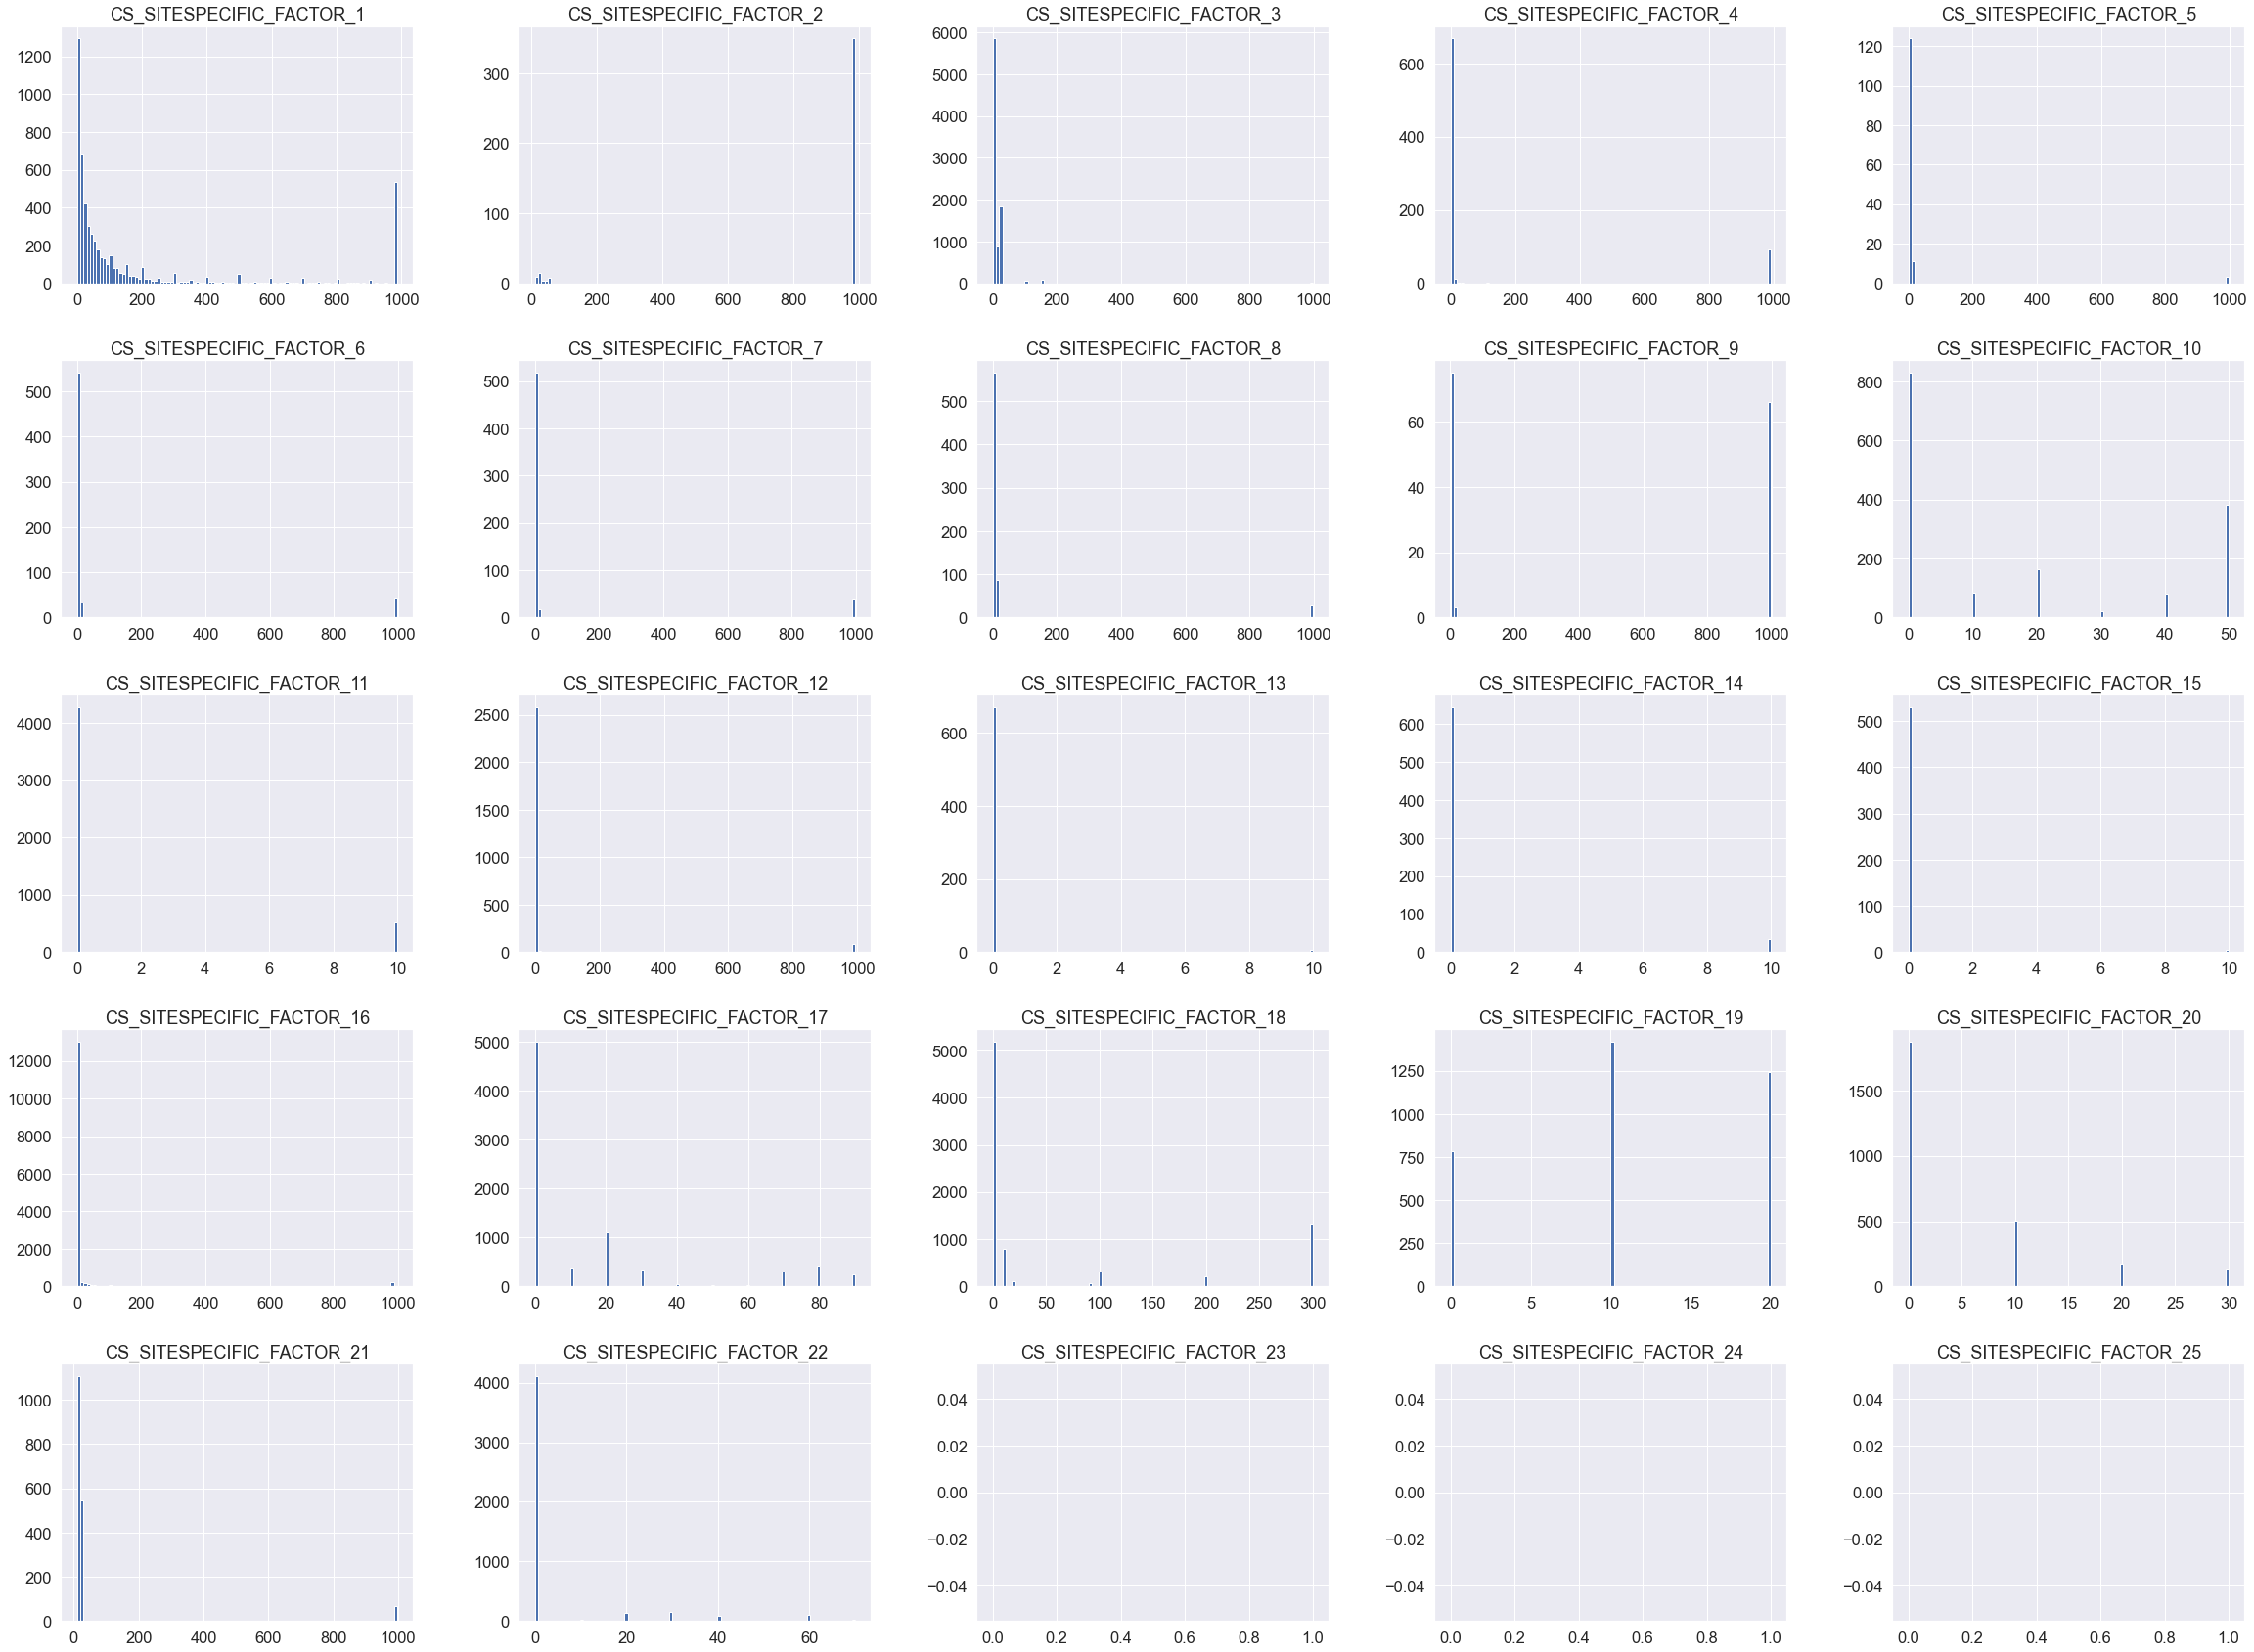

In [30]:
mcc_seer_site = mcc_seer[mcc_seer.columns.intersection(site_specific_factors)]
mcc_seer_site = mcc_seer_site.apply(lambda x: x.replace([888, 988, 990, 998, 999],
                                                        [np.nan,np.nan,np.nan,np.nan,np.nan]))
mcc_seer_site.hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [31]:
DX_RX = [
            'DX_STAGING_PROC_DAYS',
            'RX_SUMM_DXSTG_PROC',
            'DX_RX_STARTED_DAYS',
             'DX_SURG_STARTED_DAYS',
             'DX_DEFSURG_STARTED_DAYS',
             'RX_SUMM_SURG_PRIM_SITE',
             'RX_HOSP_SURG_APPR_2010',
             'RX_SUMM_SURGICAL_MARGINS',
             'RX_SUMM_SCOPE_REG_LN_SUR',
             'RX_SUMM_SURG_OTH_REGDIS',
             'DX_RAD_STARTED_DAYS',
             'RX_SUMM_RADIATION',
             'RX_SUMM_SURGRAD_SEQ',
             'DX_SYSTEMIC_STARTED_DAYS',
             'DX_CHEMO_STARTED_DAYS',
             'RX_SUMM_CHEMO',
             'DX_HORMONE_STARTED_DAYS',
             'RX_SUMM_HORMONE',
             'DX_IMMUNO_STARTED_DAYS',
             'RX_SUMM_IMMUNOTHERAPY',
             'RX_SUMM_TRNSPLNT_ENDO',
             'RX_SUMM_SYSTEMIC_SUR_SEQ',
             'DX_OTHER_STARTED_DAYS',
             'RX_SUMM_OTHER',
             'RX_SUMM_TREATMENT_STATUS',
             'DX_LASTCONTACT_DEATH_MONTHS',
             'RX_HOSP_SURG_PRIM_SITE',
             'RX_HOSP_CHEMO',
             'RX_HOSP_IMMUNOTHERAPY',
             'RX_HOSP_HORMONE',
             'RX_HOSP_OTHER',
             'RX_SUMM_SCOPE_REG_LN_2012',
             'RX_HOSP_DXSTG_PROC'
]

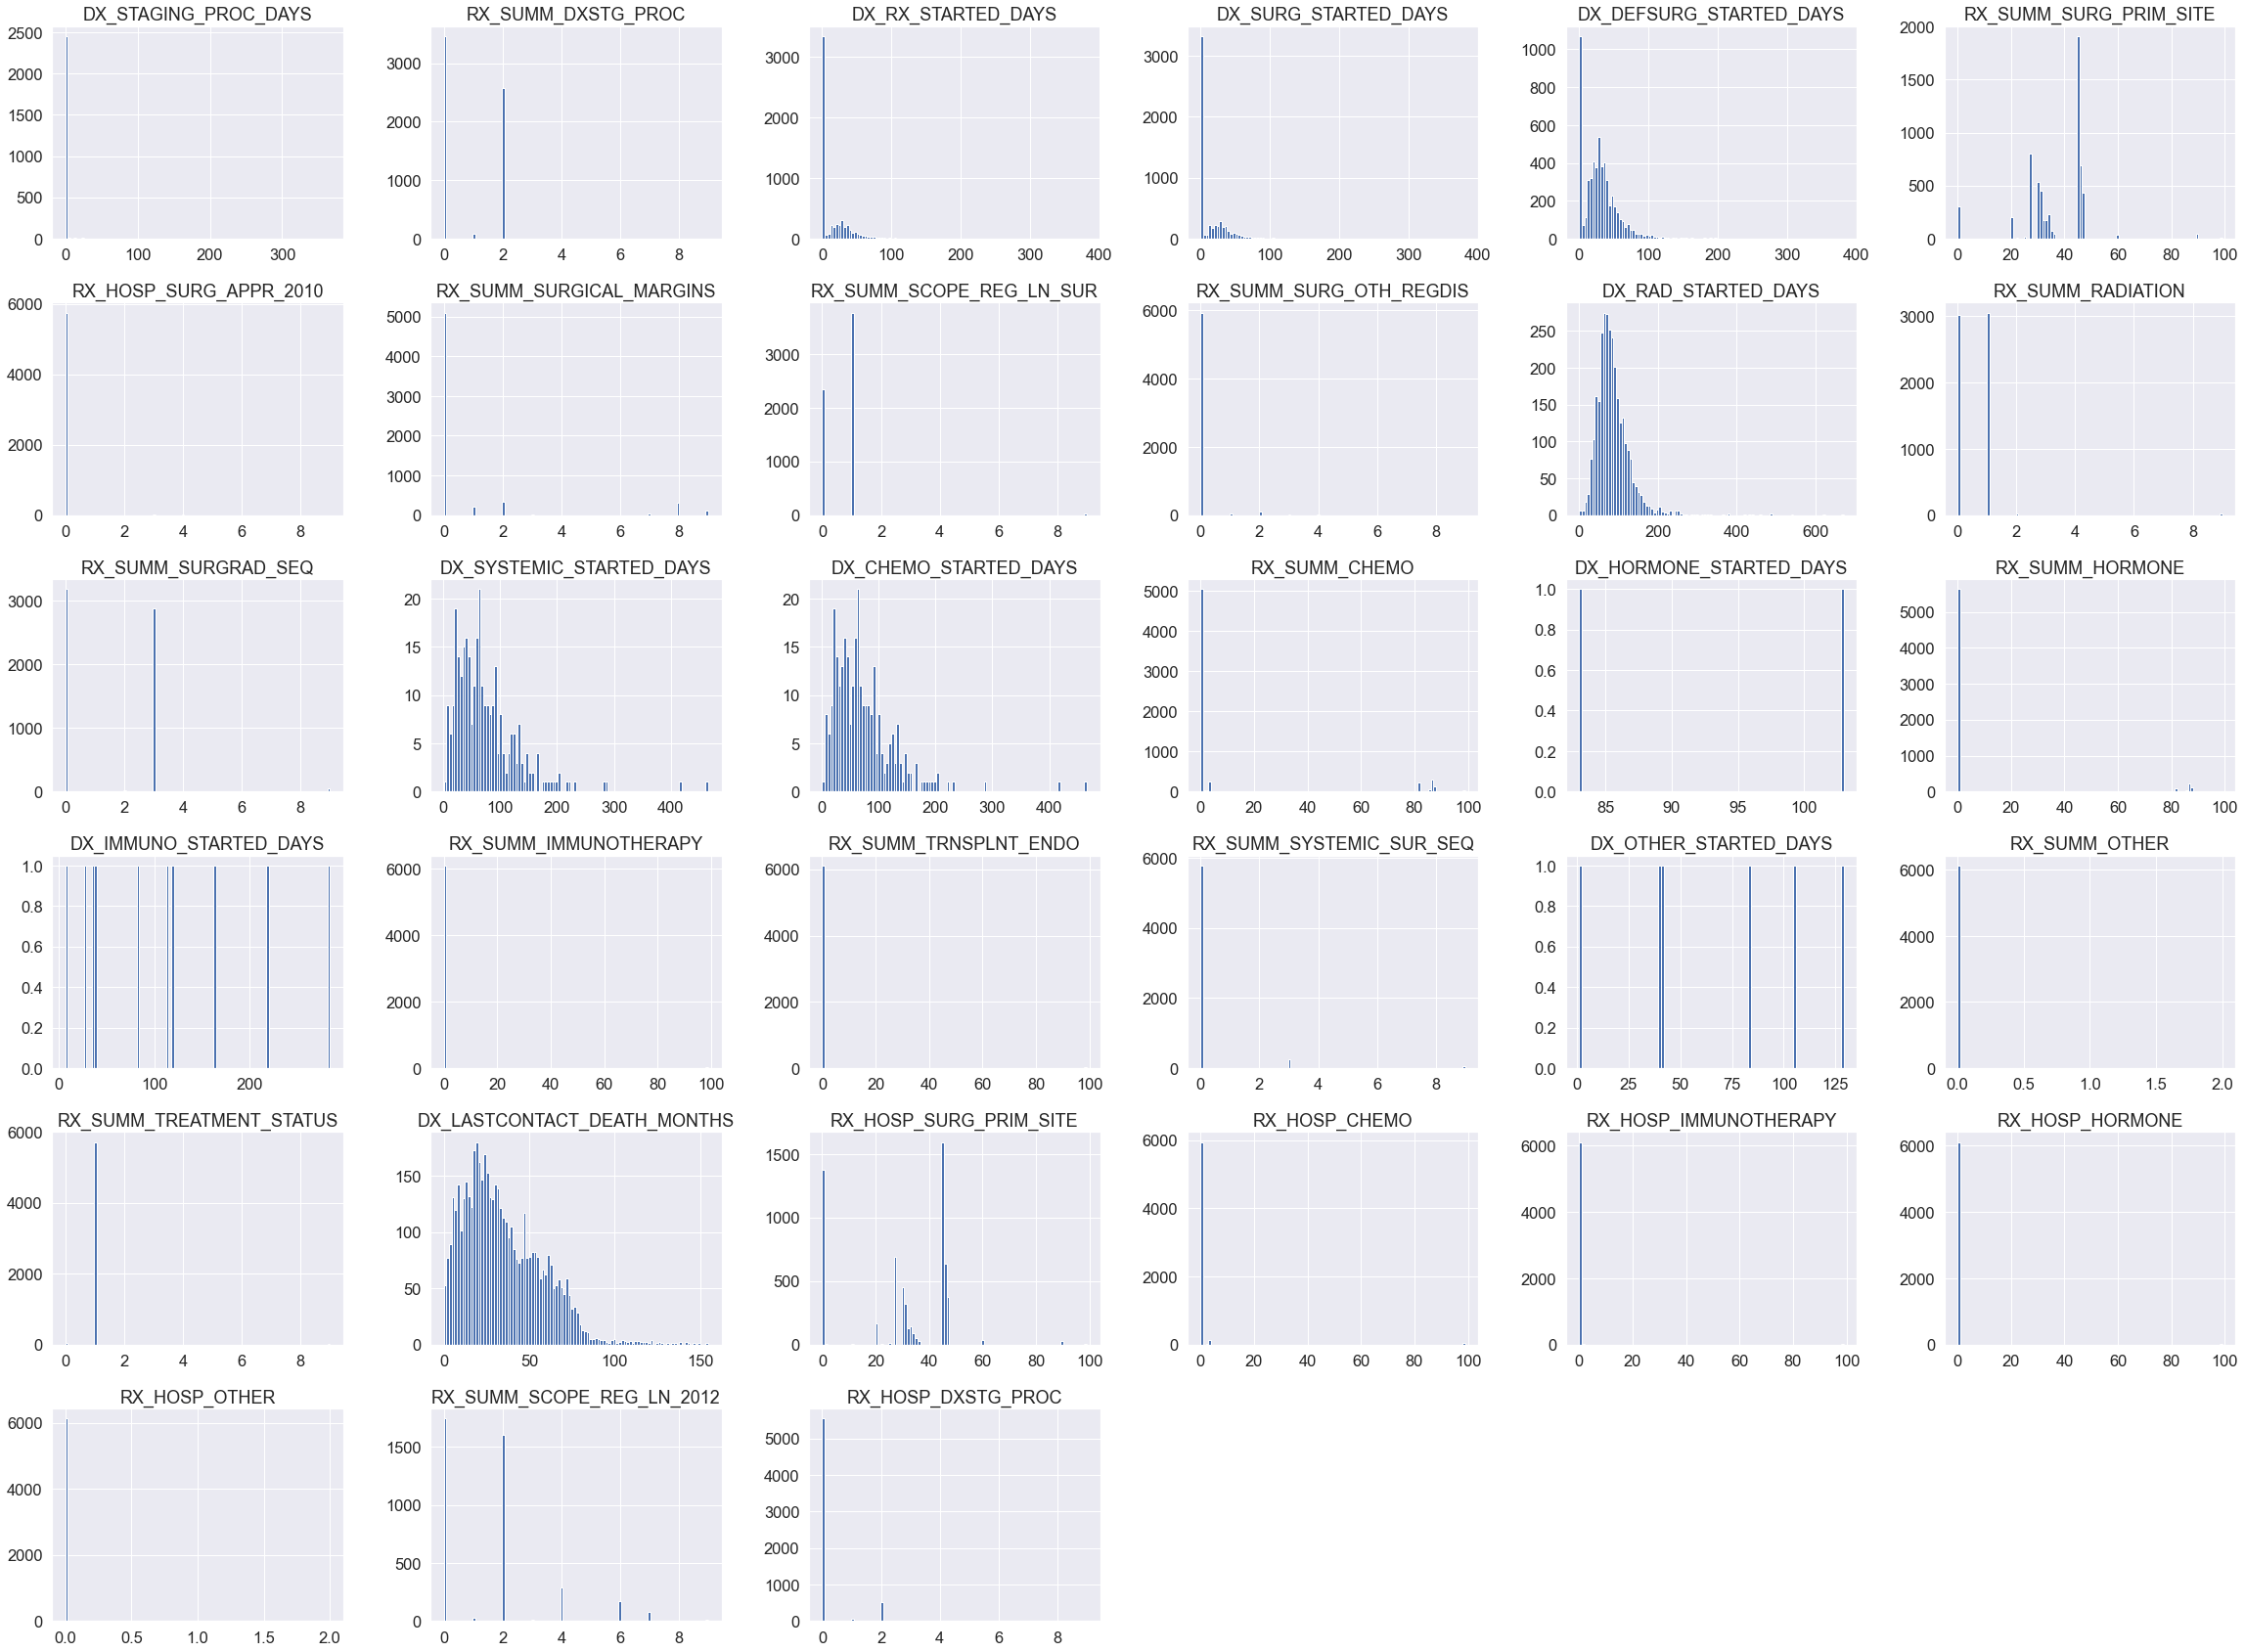

In [32]:
mcc_seer_dx_rx = mcc_seer_new[mcc_seer_new.columns.intersection(DX_RX)]
# mcc_seer_dx_rx = mcc_seer_dx_rx.apply(lambda x: x.replace([888, 988, 990, 998, 999],
#                                                         [np.nan,np.nan,np.nan,np.nan,np.nan]))
mcc_seer_dx_rx.hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [33]:
mcc_seer_categ.head()

,PRIMARY_SITE,TNM_CLIN_T,TNM_CLIN_N,TNM_CLIN_M,TNM_CLIN_STAGE_GROUP,TNM_PATH_T,TNM_PATH_N,TNM_PATH_M,TNM_PATH_STAGE_GROUP
8,C444,c1,c0,c0,1,p1,p0,NaN,NaN
14,C443,c1,c0,c0,1B,p1,p0,NaN,1A
19,C447,cX,cX,NaN,99,p2,p0,NaN,2A
23,C443,c1,c0,c0,1B,p1,pX,NaN,99
31,C447,cX,c0,c0,99,p1,p0,NaN,1A


In [34]:
mcc_seer_categ['TNM_PATH_M'].value_counts()

pX     357
p1      30
p1A     29
p1C     17
p1B      3
Name: TNM_PATH_M, dtype: int64

## Select important features and rename
- Remove those that has a lot of missing values
- Manually remove those that mostly have zero variance but omitted by our filter previously

In [35]:
features = [
             'AGE','SEX','RACE',
#              'CDCC_TOTAL_BEST',
             'YEAR_OF_DIAGNOSIS', #9999, convert to time
             'PRIMARY_SITE',
             'LATERALITY', #9
             'HISTOLOGY',
#              'BEHAVIOR',
             'GRADE', #9
#              'DIAGNOSTIC_CONFIRMATION',
             'TUMOR_SIZE', # 999
             'REGIONAL_NODES_POSITIVE', # Step 2? exclude from features later
             'REGIONAL_NODES_EXAMINED', # Step 2? exclude from features later
#              'DX_STAGING_PROC_DAYS',
             'RX_SUMM_DXSTG_PROC',
             'TNM_CLIN_T',
             'TNM_CLIN_N',
             'TNM_CLIN_M',
             'TNM_CLIN_STAGE_GROUP',
             'TNM_PATH_T',
             'TNM_PATH_N',
             'TNM_PATH_M',
             'TNM_PATH_STAGE_GROUP',
#              'TNM_EDITION_NUMBER',
             'ANALYTIC_STAGE_GROUP',
#              'CS_METS_AT_DX',
#              'CS_METS_EVAL',
#              'CS_EXTENSION',
#              'CS_TUMOR_SIZEEXT_EVAL',
#              'CS_METS_DX_BONE',
#              'CS_METS_DX_BRAIN',
#              'CS_METS_DX_LIVER',
#              'CS_METS_DX_LUNG',
             'LYMPH_VASCULAR_INVASION',
             'CS_SITESPECIFIC_FACTOR_1',
#              'CS_SITESPECIFIC_FACTOR_2',
             'CS_SITESPECIFIC_FACTOR_3',
#              'CS_SITESPECIFIC_FACTOR_4',
#              'CS_SITESPECIFIC_FACTOR_5',
#              'CS_SITESPECIFIC_FACTOR_6',
#              'CS_SITESPECIFIC_FACTOR_7',
#              'CS_SITESPECIFIC_FACTOR_8',
#              'CS_SITESPECIFIC_FACTOR_9',
#              'CS_SITESPECIFIC_FACTOR_10',
#              'CS_SITESPECIFIC_FACTOR_11',
#              'CS_SITESPECIFIC_FACTOR_12',
#              'CS_SITESPECIFIC_FACTOR_13',
#              'CS_SITESPECIFIC_FACTOR_14',
#              'CS_SITESPECIFIC_FACTOR_15',
#              'CS_SITESPECIFIC_FACTOR_16',
             'CS_SITESPECIFIC_FACTOR_17',
             'CS_SITESPECIFIC_FACTOR_18',
             'CS_SITESPECIFIC_FACTOR_19',
             'CS_SITESPECIFIC_FACTOR_20',
             'CS_SITESPECIFIC_FACTOR_21',
             'CS_SITESPECIFIC_FACTOR_22',
#              'CS_SITESPECIFIC_FACTOR_23',
#              'CS_SITESPECIFIC_FACTOR_24',
#              'CS_SITESPECIFIC_FACTOR_25',
#              'CS_VERSION_LATEST',
             'DX_RX_STARTED_DAYS',
             'DX_SURG_STARTED_DAYS',
             'DX_DEFSURG_STARTED_DAYS',
             'RX_SUMM_SURG_PRIM_SITE',
#              'RX_HOSP_SURG_APPR_2010',
             'RX_SUMM_SURGICAL_MARGINS',
             'RX_SUMM_SCOPE_REG_LN_SUR',
#              'RX_SUMM_SURG_OTH_REGDIS',
#              'SURG_DISCHARGE_DAYS',
             'READM_HOSP_30_DAYS',
#              'REASON_FOR_NO_SURGERY',
             'DX_RAD_STARTED_DAYS',
             'RX_SUMM_RADIATION',
             'RAD_LOCATION_OF_RX',
             'RAD_TREAT_VOL',
             'RAD_REGIONAL_RX_MODALITY',
             'RAD_REGIONAL_DOSE_CGY',
             'RAD_BOOST_RX_MODALITY',
             'RAD_BOOST_DOSE_CGY', #88888,99999
             'RAD_NUM_TREAT_VOL', #999
             'RX_SUMM_SURGRAD_SEQ',
             'RAD_ELAPSED_RX_DAYS',
             'REASON_FOR_NO_RADIATION',
             'DX_SYSTEMIC_STARTED_DAYS',
             'DX_CHEMO_STARTED_DAYS',
             'RX_SUMM_CHEMO',
#              'DX_HORMONE_STARTED_DAYS',
#              'RX_SUMM_HORMONE',
#              'DX_IMMUNO_STARTED_DAYS',
#              'RX_SUMM_IMMUNOTHERAPY',
#              'RX_SUMM_TRNSPLNT_ENDO',
#              'RX_SUMM_SYSTEMIC_SUR_SEQ',
#              'DX_OTHER_STARTED_DAYS',
#              'RX_SUMM_OTHER',
#              'PALLIATIVE_CARE',
#              'RX_SUMM_TREATMENT_STATUS',
#              'PUF_30_DAY_MORT_CD', # SURVIVAL?
#              'PUF_90_DAY_MORT_CD', # SURVIVAL?
#              'DX_LASTCONTACT_DEATH_MONTHS', # SURVIVAL
#              'PUF_VITAL_STATUS', # SURVIVAL
             'RX_HOSP_SURG_PRIM_SITE',
#              'RX_HOSP_CHEMO',
#              'RX_HOSP_IMMUNOTHERAPY',
#              'RX_HOSP_HORMONE',
#              'RX_HOSP_OTHER',
#              'PUF_MULT_SOURCE',
#              'PUF_REFERENCE_DATE_FLAG',
             'RX_SUMM_SCOPE_REG_LN_2012',
#              'RX_HOSP_DXSTG_PROC',
#              'PALLIATIVE_CARE_HOSP'
           ]

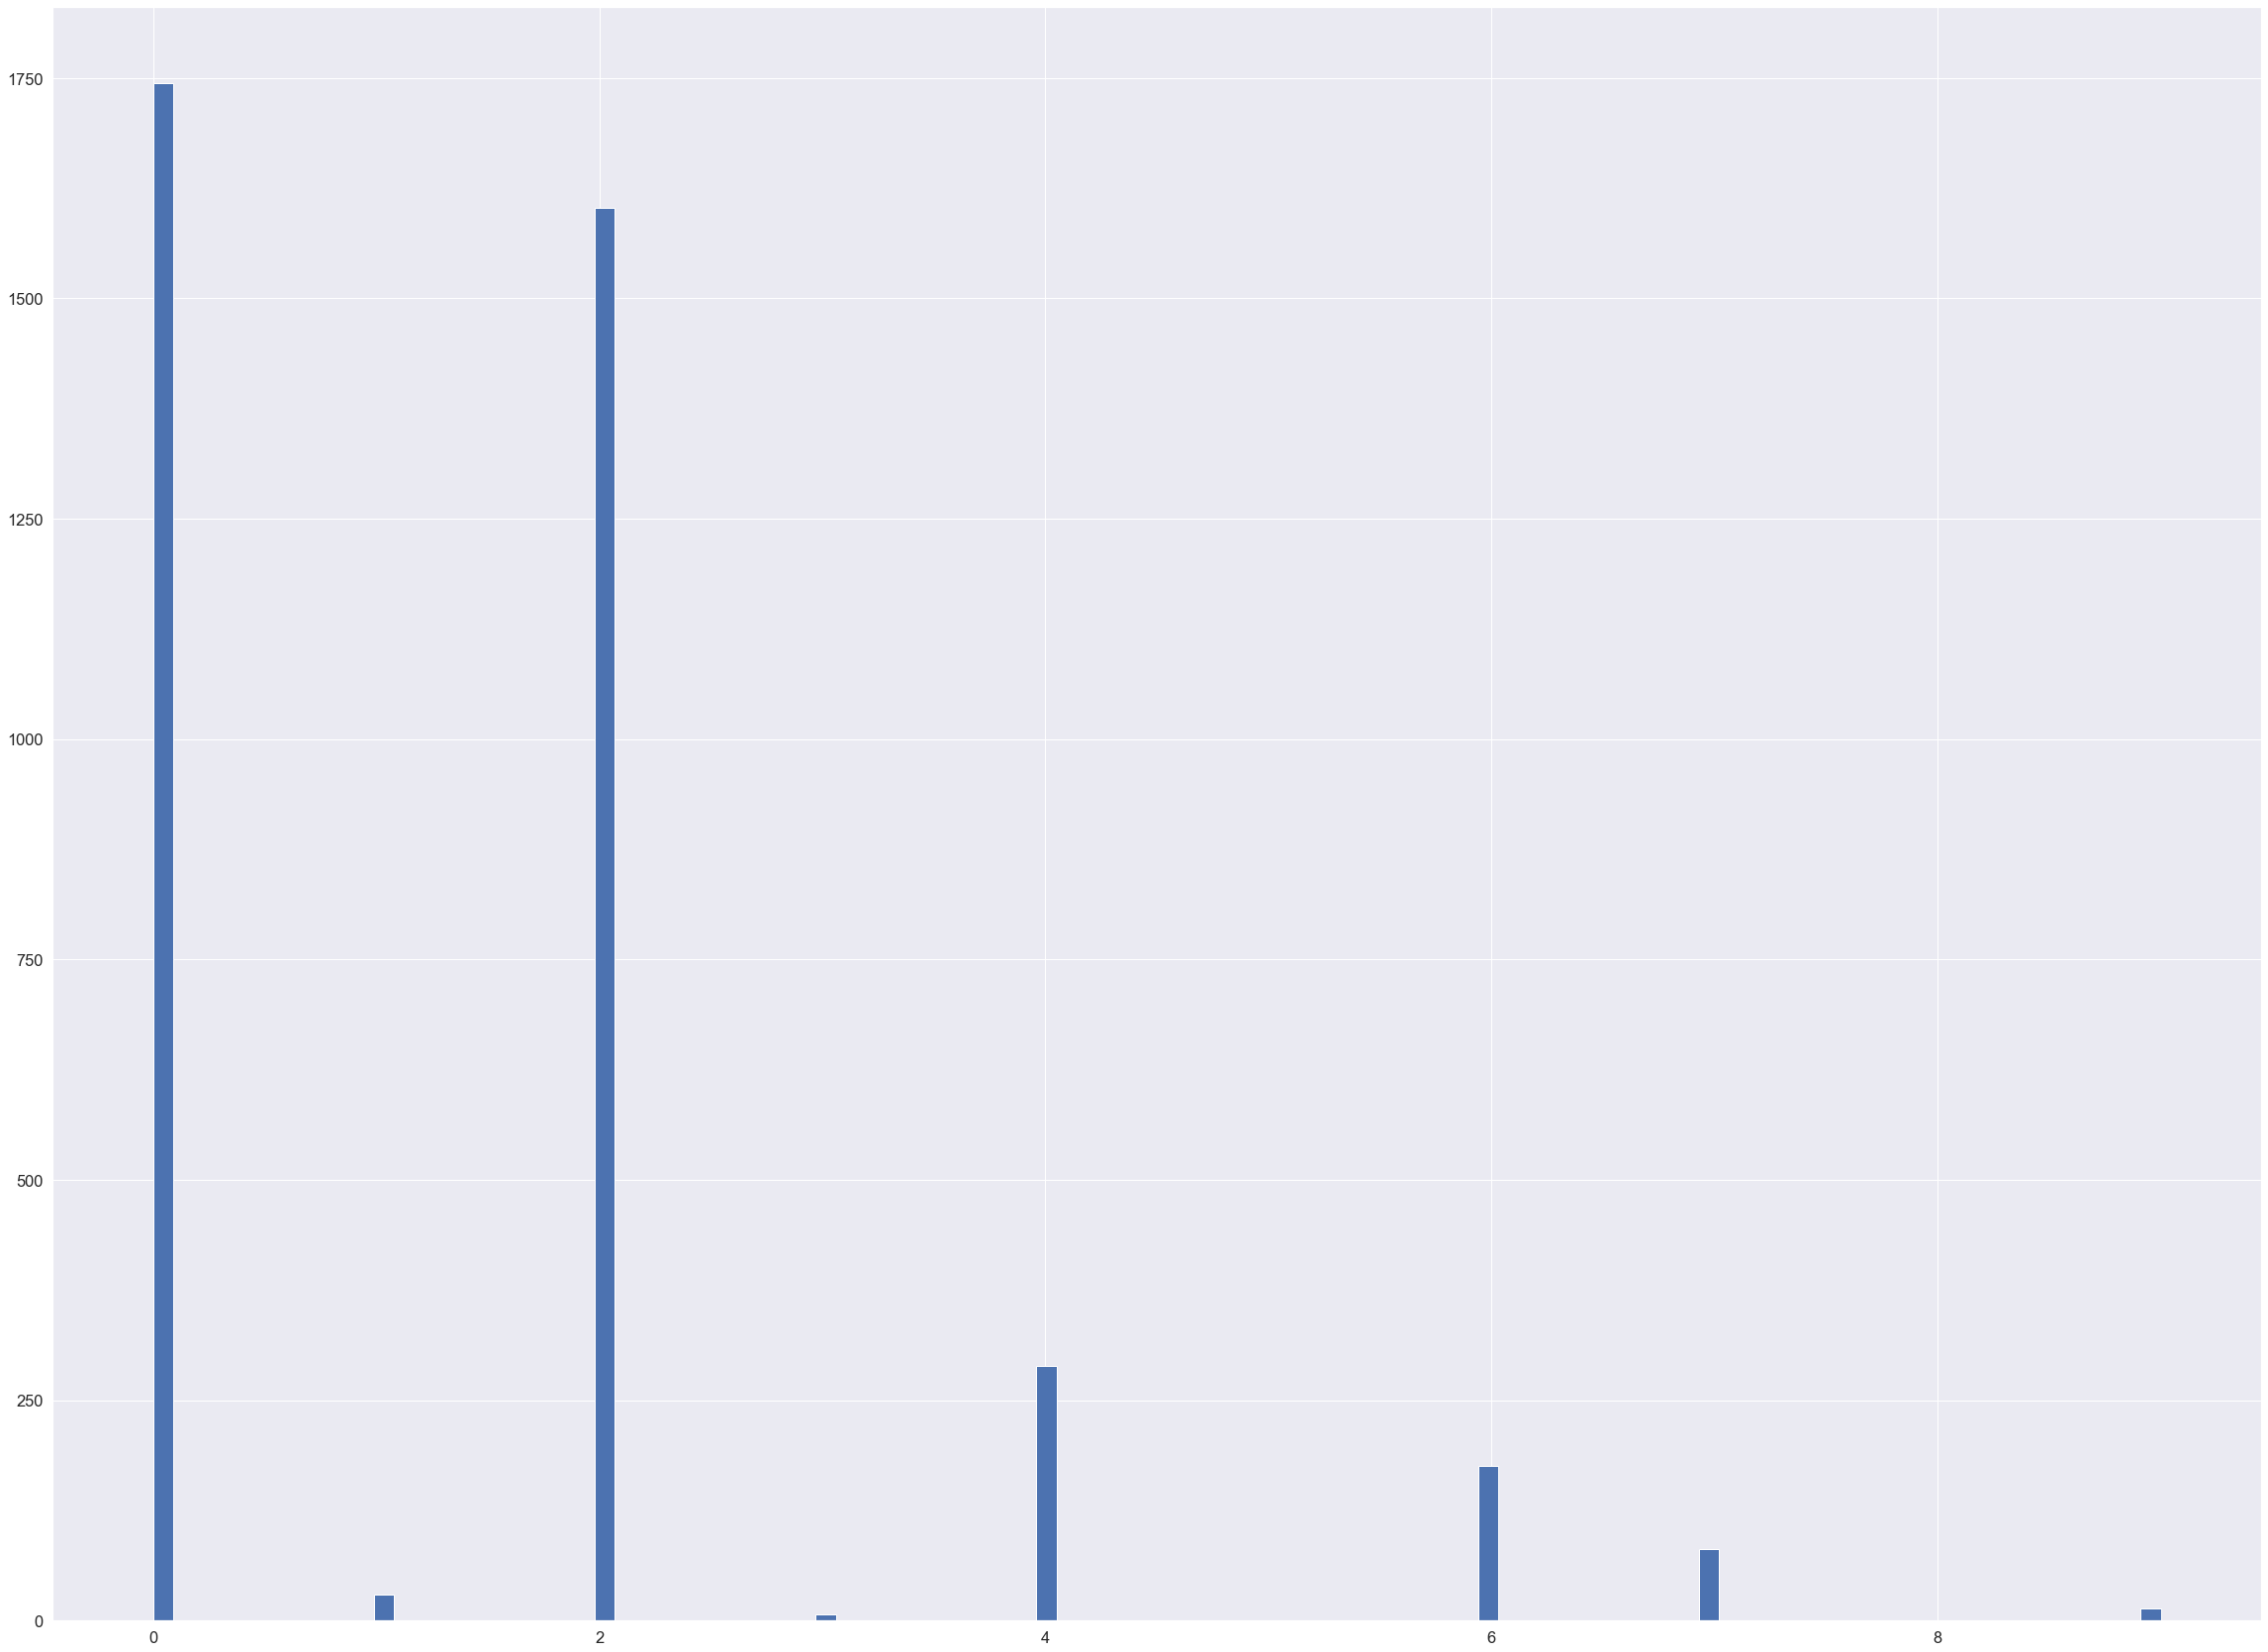

In [36]:
mcc_seer_new['RX_SUMM_SCOPE_REG_LN_2012'].hist(bins=100, figsize=(40,30))
plt.rcParams.update({'font.size': 24})
plt.show()

In [37]:
mcc_seer = mcc_seer_new.loc[:,features]

In [38]:
mcc_seer.shape

(6136, 54)

In [39]:
target

8        0.0
14       0.0
19       0.0
23       0.0
31       0.0
        ... 
34483    0.0
34554    0.0
34677    0.0
34738    0.0
34767    1.0
Name: CS_SITESPECIFIC_FACTOR_3, Length: 6136, dtype: float64

## Check if SLNB positive (response) agrees with others (REGIONAL_NODES_POSITIVE)

In [40]:
pd.crosstab(mcc_seer['REGIONAL_NODES_POSITIVE'], target)

CS_SITESPECIFIC_FACTOR_3,0.0,1.0
REGIONAL_NODES_POSITIVE,,
0,2874,35
1,6,483
2,2,171
3,2,57
4,0,30
6,0,9
7,0,4
8,0,8
9,0,6


In [41]:
# remove those entries with negative SLNB but have positive regional nodes
cond = ((mcc_seer['CS_SITESPECIFIC_FACTOR_3'] == 0.0) & \
    (mcc_seer['REGIONAL_NODES_POSITIVE'] > 0) & \
    (mcc_seer['REGIONAL_NODES_POSITIVE'] < 98)) 
mcc_seer = mcc_seer.drop(mcc_seer[cond].index)

In [42]:
# save to csv
mcc_seer.to_csv(BASE_DIR+"../data/Merkel_seer_1.csv")

## Further perform feature selection by recursive feature elimination using random forest (in R)

Preliminary features by RF:

- ANALYTIC_STAGE_GROUP (STAGE)
- DX_SYSTEMIC_STARTED_DAYS (SYSTEMIC_DELAY_DAYS)
- DX_CHEMO_STARTED_DAYS (CHEMO_DELAY_DAYS)
- RX_HOSP_SURG_PRIM_SITE (SURGERY)
- DX_RA D_STARTED_DAYS (RAD_DELAY_DAYS)
- RX_SUMM_DXSTG_PROC (DXSTG_PROC)
- DX_DEFSURG_STARTED_DAYS (DEFSURG_DELAY_DAYS)
- RAD_REGIONAL_RX_MODALITY (RAD_MODALITY)
- CS_SITESPECIFIC_FACTOR_1 (DEPTH)
- TUMOR_SIZE              
- DX_SURG_STARTED_DAYS (SURG_DELAY_DAYS)   
- RAD_TREAT_VOL
- PRIMARY_SITE              
- AGE                       
- DX_RX_STARTED_DAYS (TREATMENT_DAYS)       
- RX_SUMM_SURGICAL_MARGINS (SURGICAL_MARGINS)
- READM_HOSP_30_DAYS      
- CS_SITESPECIFIC_FACTOR_21 (GROWTH_PATTERN)
- HISTOLOGY                 
- RAD_ELAPSED_RX_DAYS (RAD_DAYS)        
- LYMPH_VASCULAR_INVASION    
- RAD_BOOST_RX_MODALITY (RAD_BOOST_MODALITY)  
- RAD_LOCATION_OF_RX (RAD_LOCATION)     
- RAD_BOOST_DOSE_CGY (RAD_BOOST_DOSE)    
- RX_SUMM_CHEMO (CHEMO)         
- CS_SITESPECIFIC_FACTOR_20 (TUMOR_INFILTRATING_LYMPHOCYTES)
- CS_SITESPECIFIC_FACTOR_22 (IMMUNE_SUPPRESSION)
- CS_SITESPECIFIC_FACTOR_19 (TUMOR_BASE_TRANSFECTION)
- RAD_NUM_TREAT_VOL (RAD_NUM)     
- RAD_REGIONAL_DOSE_CGY (RAD_DOSE)
- YEAR_OF_DIAGNOSIS (CONVERT TO YEAR_SINCE_DIAGNOSIS)
- LATERALITY
- SEX

Combining **domain knowledge**, list of features selected for EDA:

- CS_SITESPECIFIC_FACTOR_1 (DEPTH)
- TUMOR_SIZE              
- PRIMARY_SITE              
- AGE
- SEX
- YEAR_OF_DIAGNOSIS -> YEAR_SINCE_DIAGNOSIS (x)
- CS_SITESPECIFIC_FACTOR_21 (GROWTH_PATTERN)
- HISTOLOGY                
- LATERALITY (x)
- LYMPH_VASCULAR_INVASION    
- CS_SITESPECIFIC_FACTOR_20 (TUMOR_INFILTRATING_LYMPHOCYTES)
- CS_SITESPECIFIC_FACTOR_22 (IMMUNE_SUPPRESSION)
- CS_SITESPECIFIC_FACTOR_19 (TUMOR_BASE_TRANSECTION)


In [73]:
features = ['CS_SITESPECIFIC_FACTOR_1',
            'TUMOR_SIZE',              
            'PRIMARY_SITE',              
            'AGE',
            'SEX',
            'YEAR_OF_DIAGNOSIS', # not matter much
            'CS_SITESPECIFIC_FACTOR_21',
            'HISTOLOGY',      
            'LATERALITY', # not matter much
            'LYMPH_VASCULAR_INVASION',    
            'CS_SITESPECIFIC_FACTOR_20',
            'CS_SITESPECIFIC_FACTOR_22',
            'CS_SITESPECIFIC_FACTOR_19',
            'CS_SITESPECIFIC_FACTOR_3',
           ]
mcc_seer = pd.read_csv(BASE_DIR+"../data/Merkel_seer_1.csv", index_col=0)
mcc_seer = mcc_seer[features].rename(columns={'CS_SITESPECIFIC_FACTOR_1':'DEPTH',
                                              'CS_SITESPECIFIC_FACTOR_21':'GROWTH_PATTERN',
                                              'CS_SITESPECIFIC_FACTOR_20':'TUMOR_INFILTRATING_LYMPHOCYTES',
                                              'CS_SITESPECIFIC_FACTOR_22':'IMMUNE_SUPPRESSION',
                                              'CS_SITESPECIFIC_FACTOR_19':'TUMOR_BASE_TRANSECTION',
                                              'CS_SITESPECIFIC_FACTOR_3':'SLNB'
                                             })

In [74]:
mcc_seer.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,YEAR_OF_DIAGNOSIS,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSECTION,SLNB
8,999.0,1,C444,71,1,2010,999.0,8247,0,0.0,999.0,999.0,999.0,0.0
14,1.0,2,C443,43,1,2013,999.0,8247,2,9.0,0.0,0.0,20.0,0.0
19,50.0,25,C447,59,2,2013,999.0,8247,1,0.0,999.0,999.0,999.0,0.0
23,999.0,14,C443,82,2,2012,1.0,8247,2,0.0,999.0,0.0,20.0,0.0
31,62.0,15,C447,90,1,2013,999.0,8247,1,0.0,999.0,999.0,20.0,0.0


## Distributions

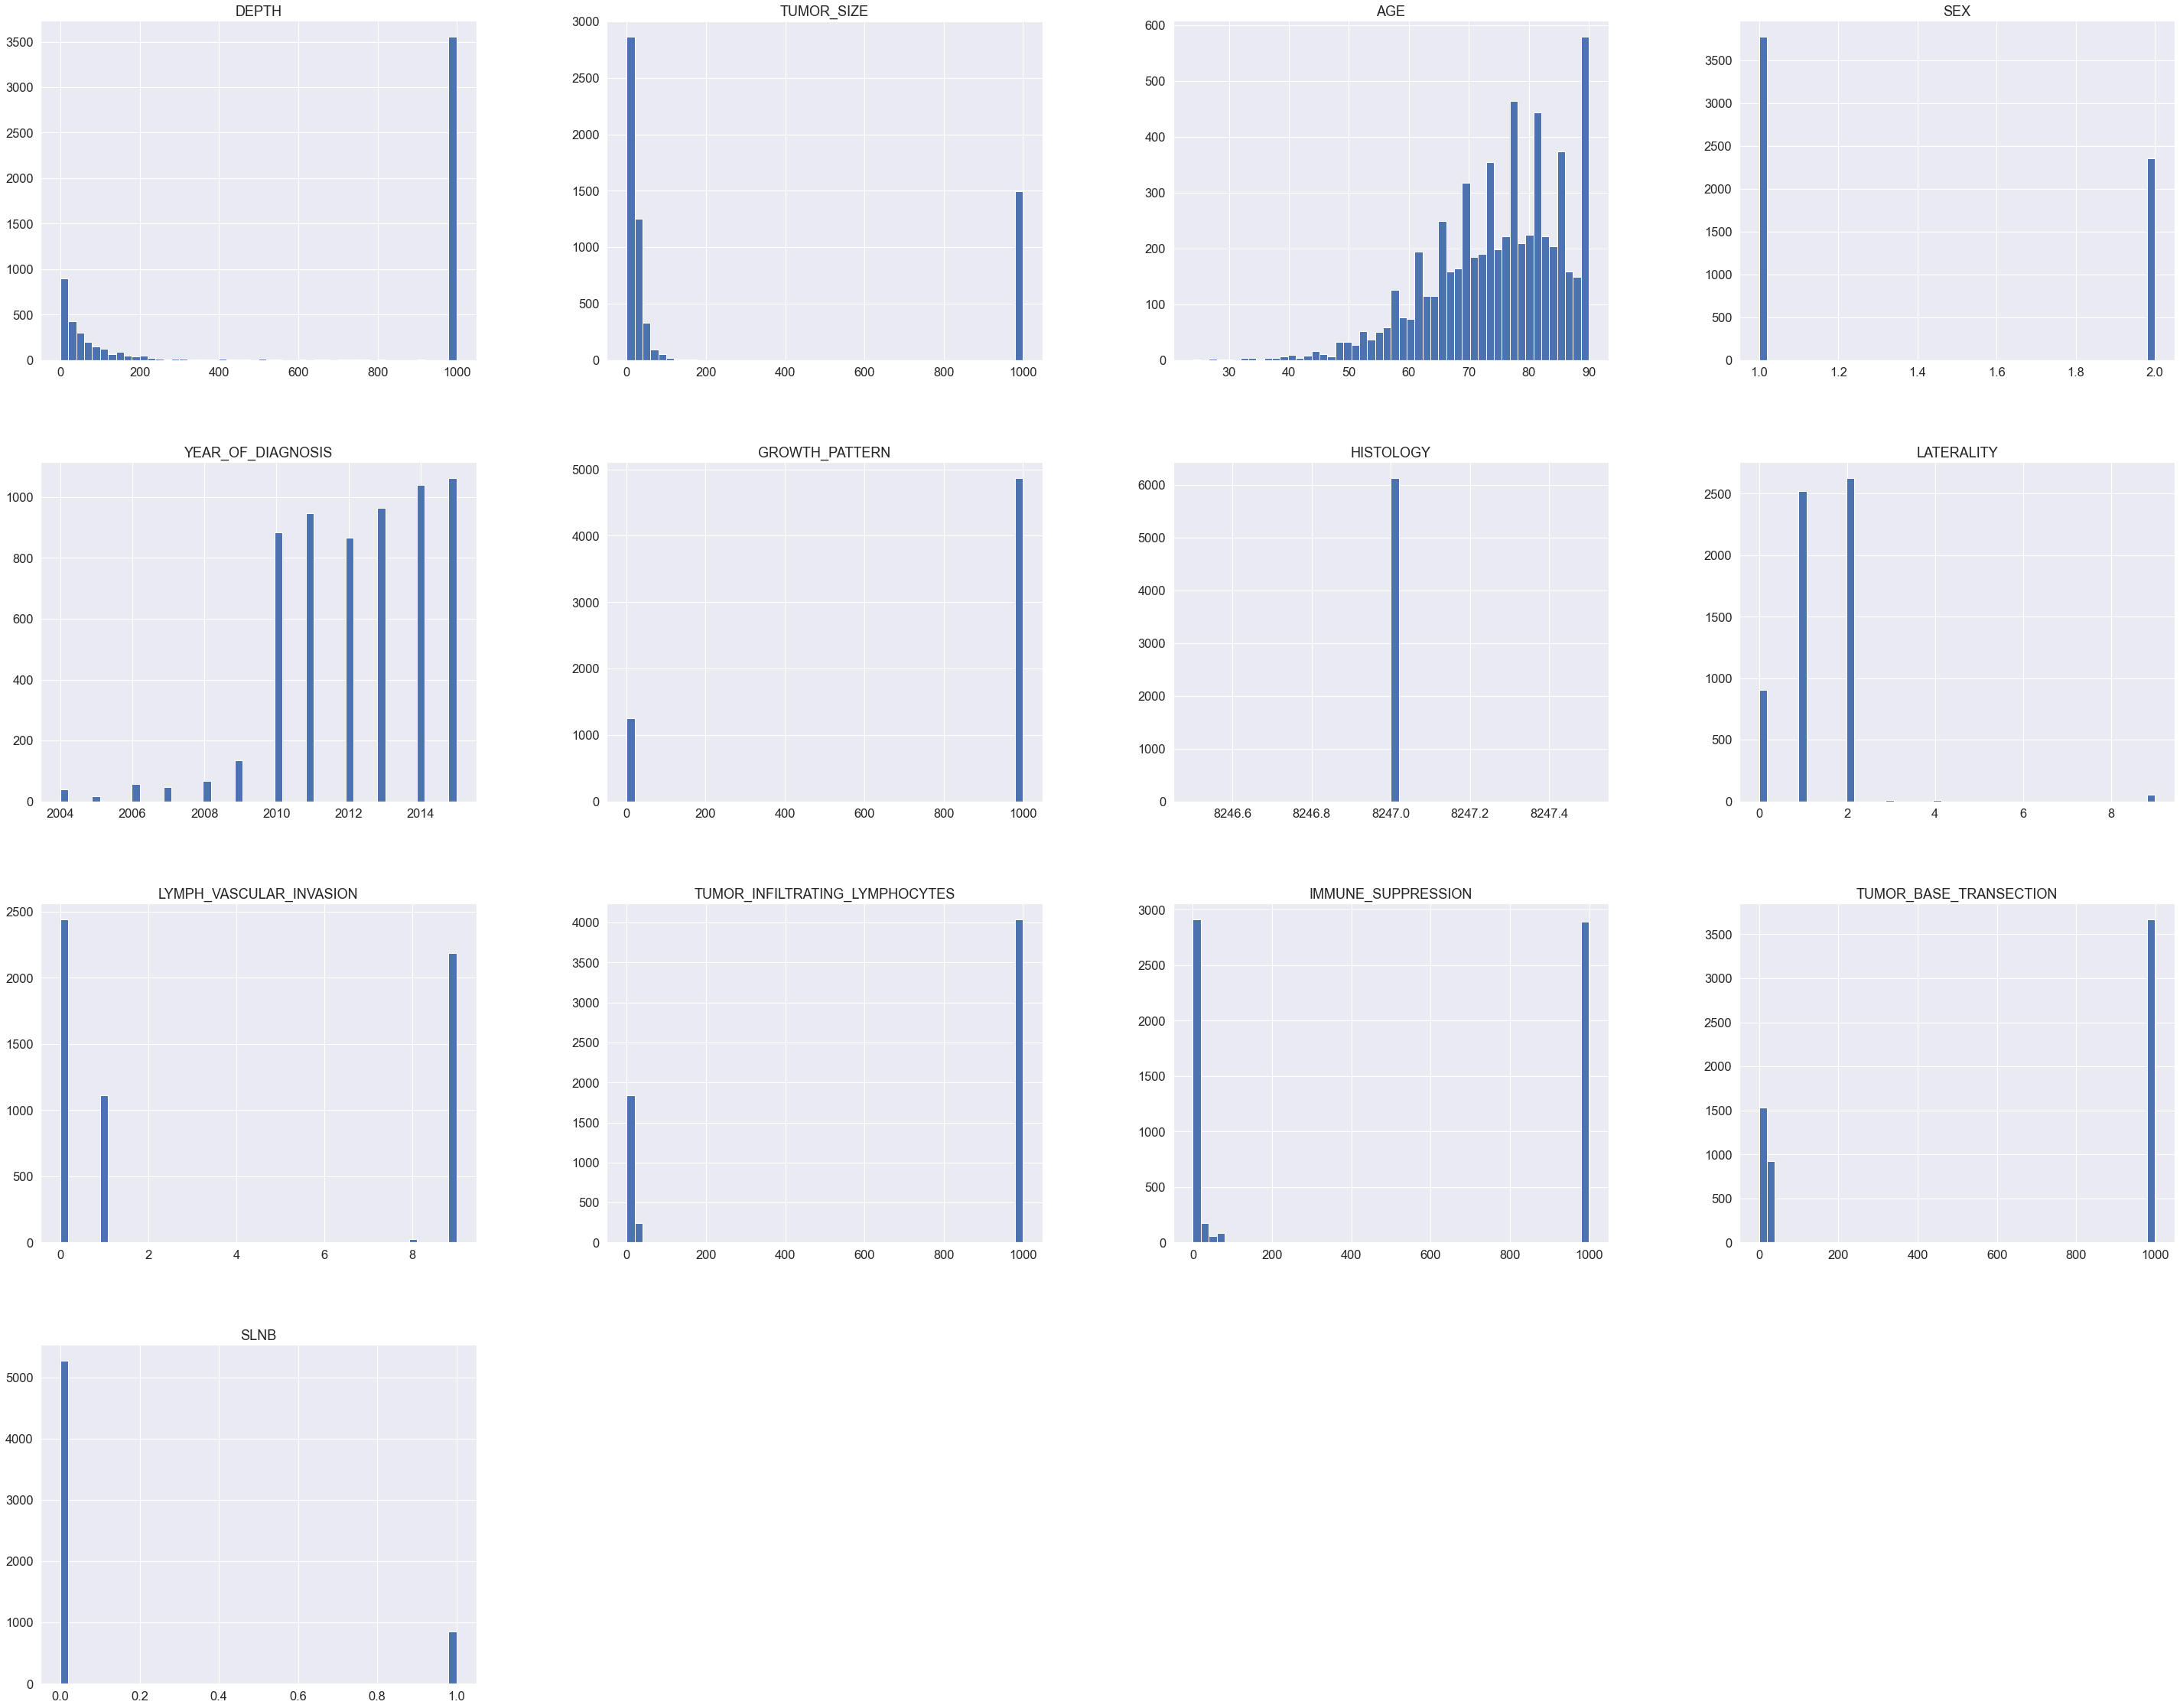

In [45]:
mcc_seer.drop(['PRIMARY_SITE'],axis=1).hist(bins=50, figsize=(50,40))
plt.rcParams.update({'font.size': 32})
plt.show()

## Combining label codings (TODO: Change later, impute?)
- DEPTH (988, 990, 998, 999)
- GROWTH_PATTERN (030,988,997,998,999)
- TUMOR_SIZE (990, 999)
- TUMOR_INFILTRATING_LYMPHOCYTES (988,998,999)
- IMMUNE_SUPPRESSION (988,999)
- TUMOR_BASE_TRANSECTION (988,998,999)

In [75]:
mcc_seer['DEPTH'] = mcc_seer['DEPTH'].replace([988, 990, 998], 
                                              [999, 999, 999])
mcc_seer['GROWTH_PATTERN'] = mcc_seer['GROWTH_PATTERN'].replace([30, 988, 997, 998],
                                                                [999, 999, 999, 999])

mcc_seer['TUMOR_SIZE'] = mcc_seer['TUMOR_SIZE'].replace([990], [999])
mcc_seer['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_seer['TUMOR_INFILTRATING_LYMPHOCYTES'].replace([988, 998],
                                                                                                [999, 999])
mcc_seer['IMMUNE_SUPPRESSION'] = mcc_seer['IMMUNE_SUPPRESSION'].replace([988], [999])
mcc_seer['TUMOR_BASE_TRANSECTION'] = mcc_seer['TUMOR_BASE_TRANSECTION'].replace([988, 998],
                                                                                  [999, 999])


In [76]:
# missing value
_ = mcc_seer.apply(lambda x: print("{}\t{}".format(x.name, x.isnull().sum())))

# fill NaN for LYMPH_VASCULAR_INVASION as 9
mcc_seer['LYMPH_VASCULAR_INVASION'] = mcc_seer['LYMPH_VASCULAR_INVASION'].fillna(9)

DEPTH	0
TUMOR_SIZE	0
PRIMARY_SITE	0
AGE	0
SEX	0
YEAR_OF_DIAGNOSIS	0
GROWTH_PATTERN	0
HISTOLOGY	0
LATERALITY	0
LYMPH_VASCULAR_INVASION	359
TUMOR_INFILTRATING_LYMPHOCYTES	0
IMMUNE_SUPPRESSION	0
TUMOR_BASE_TRANSECTION	0
SLNB	0


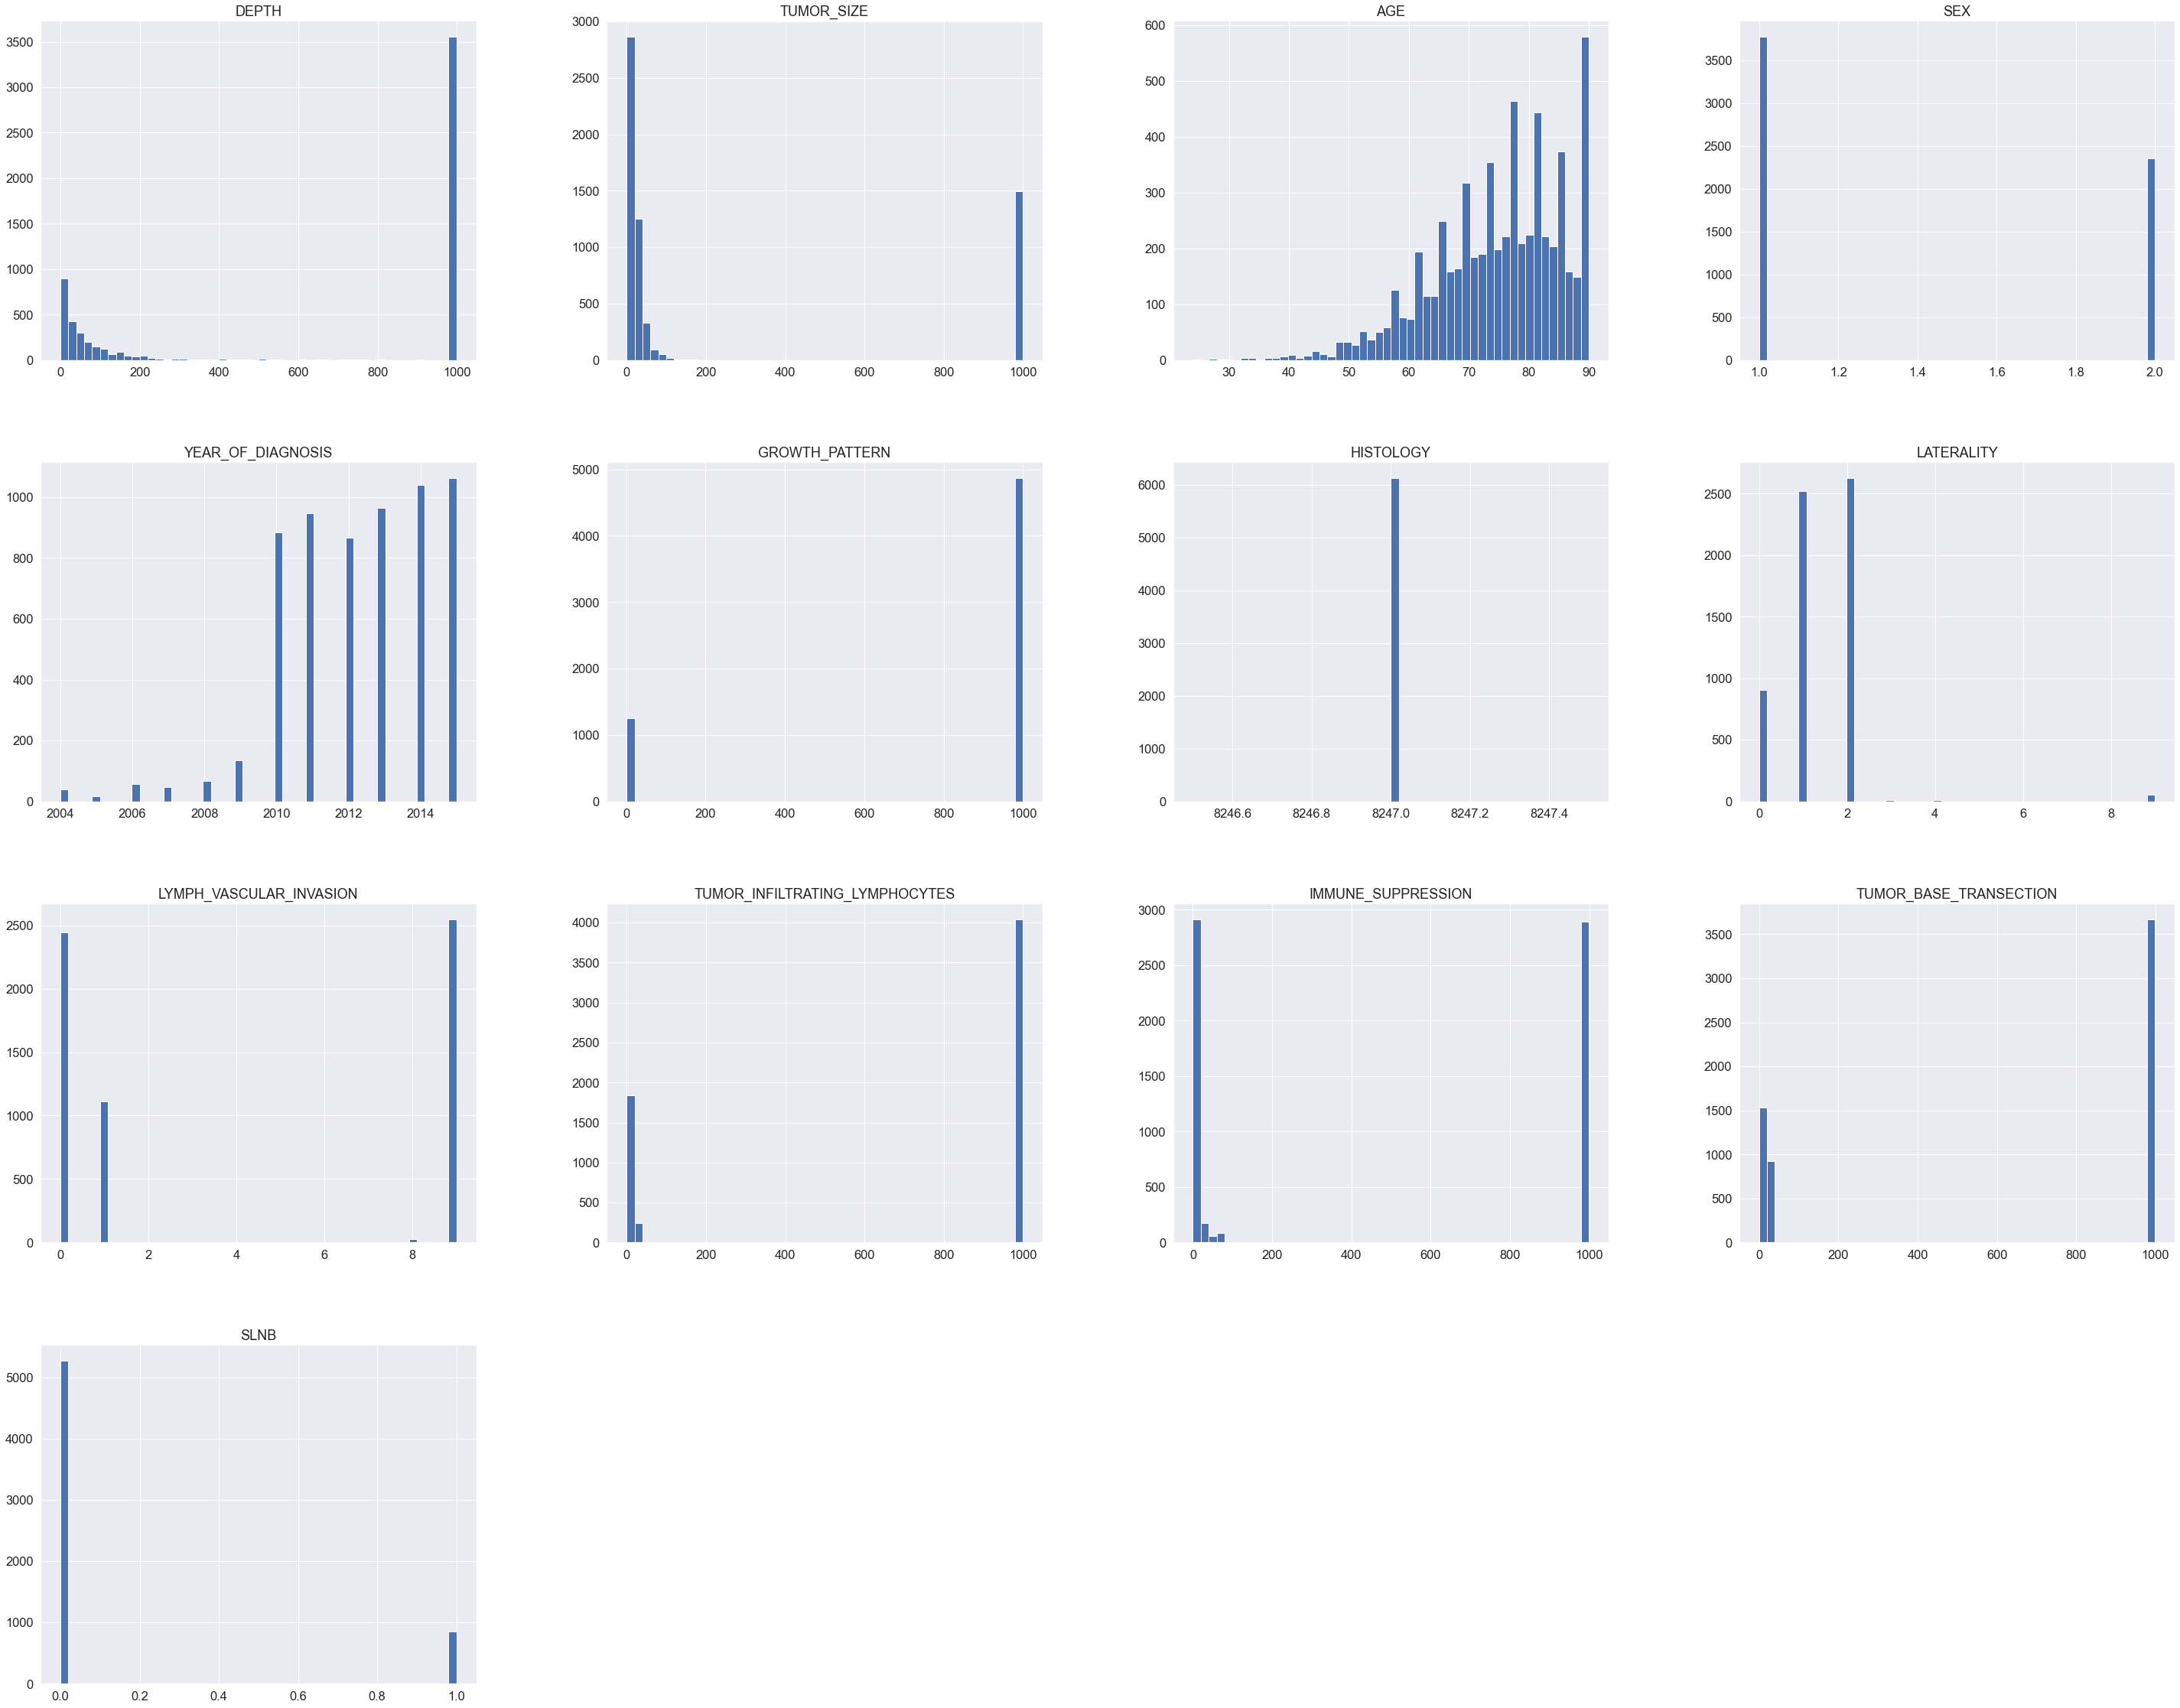

In [48]:
mcc_seer.drop(['PRIMARY_SITE'],axis=1).hist(bins=50, figsize=(50,40))
plt.rcParams.update({'font.size': 32})
plt.show()

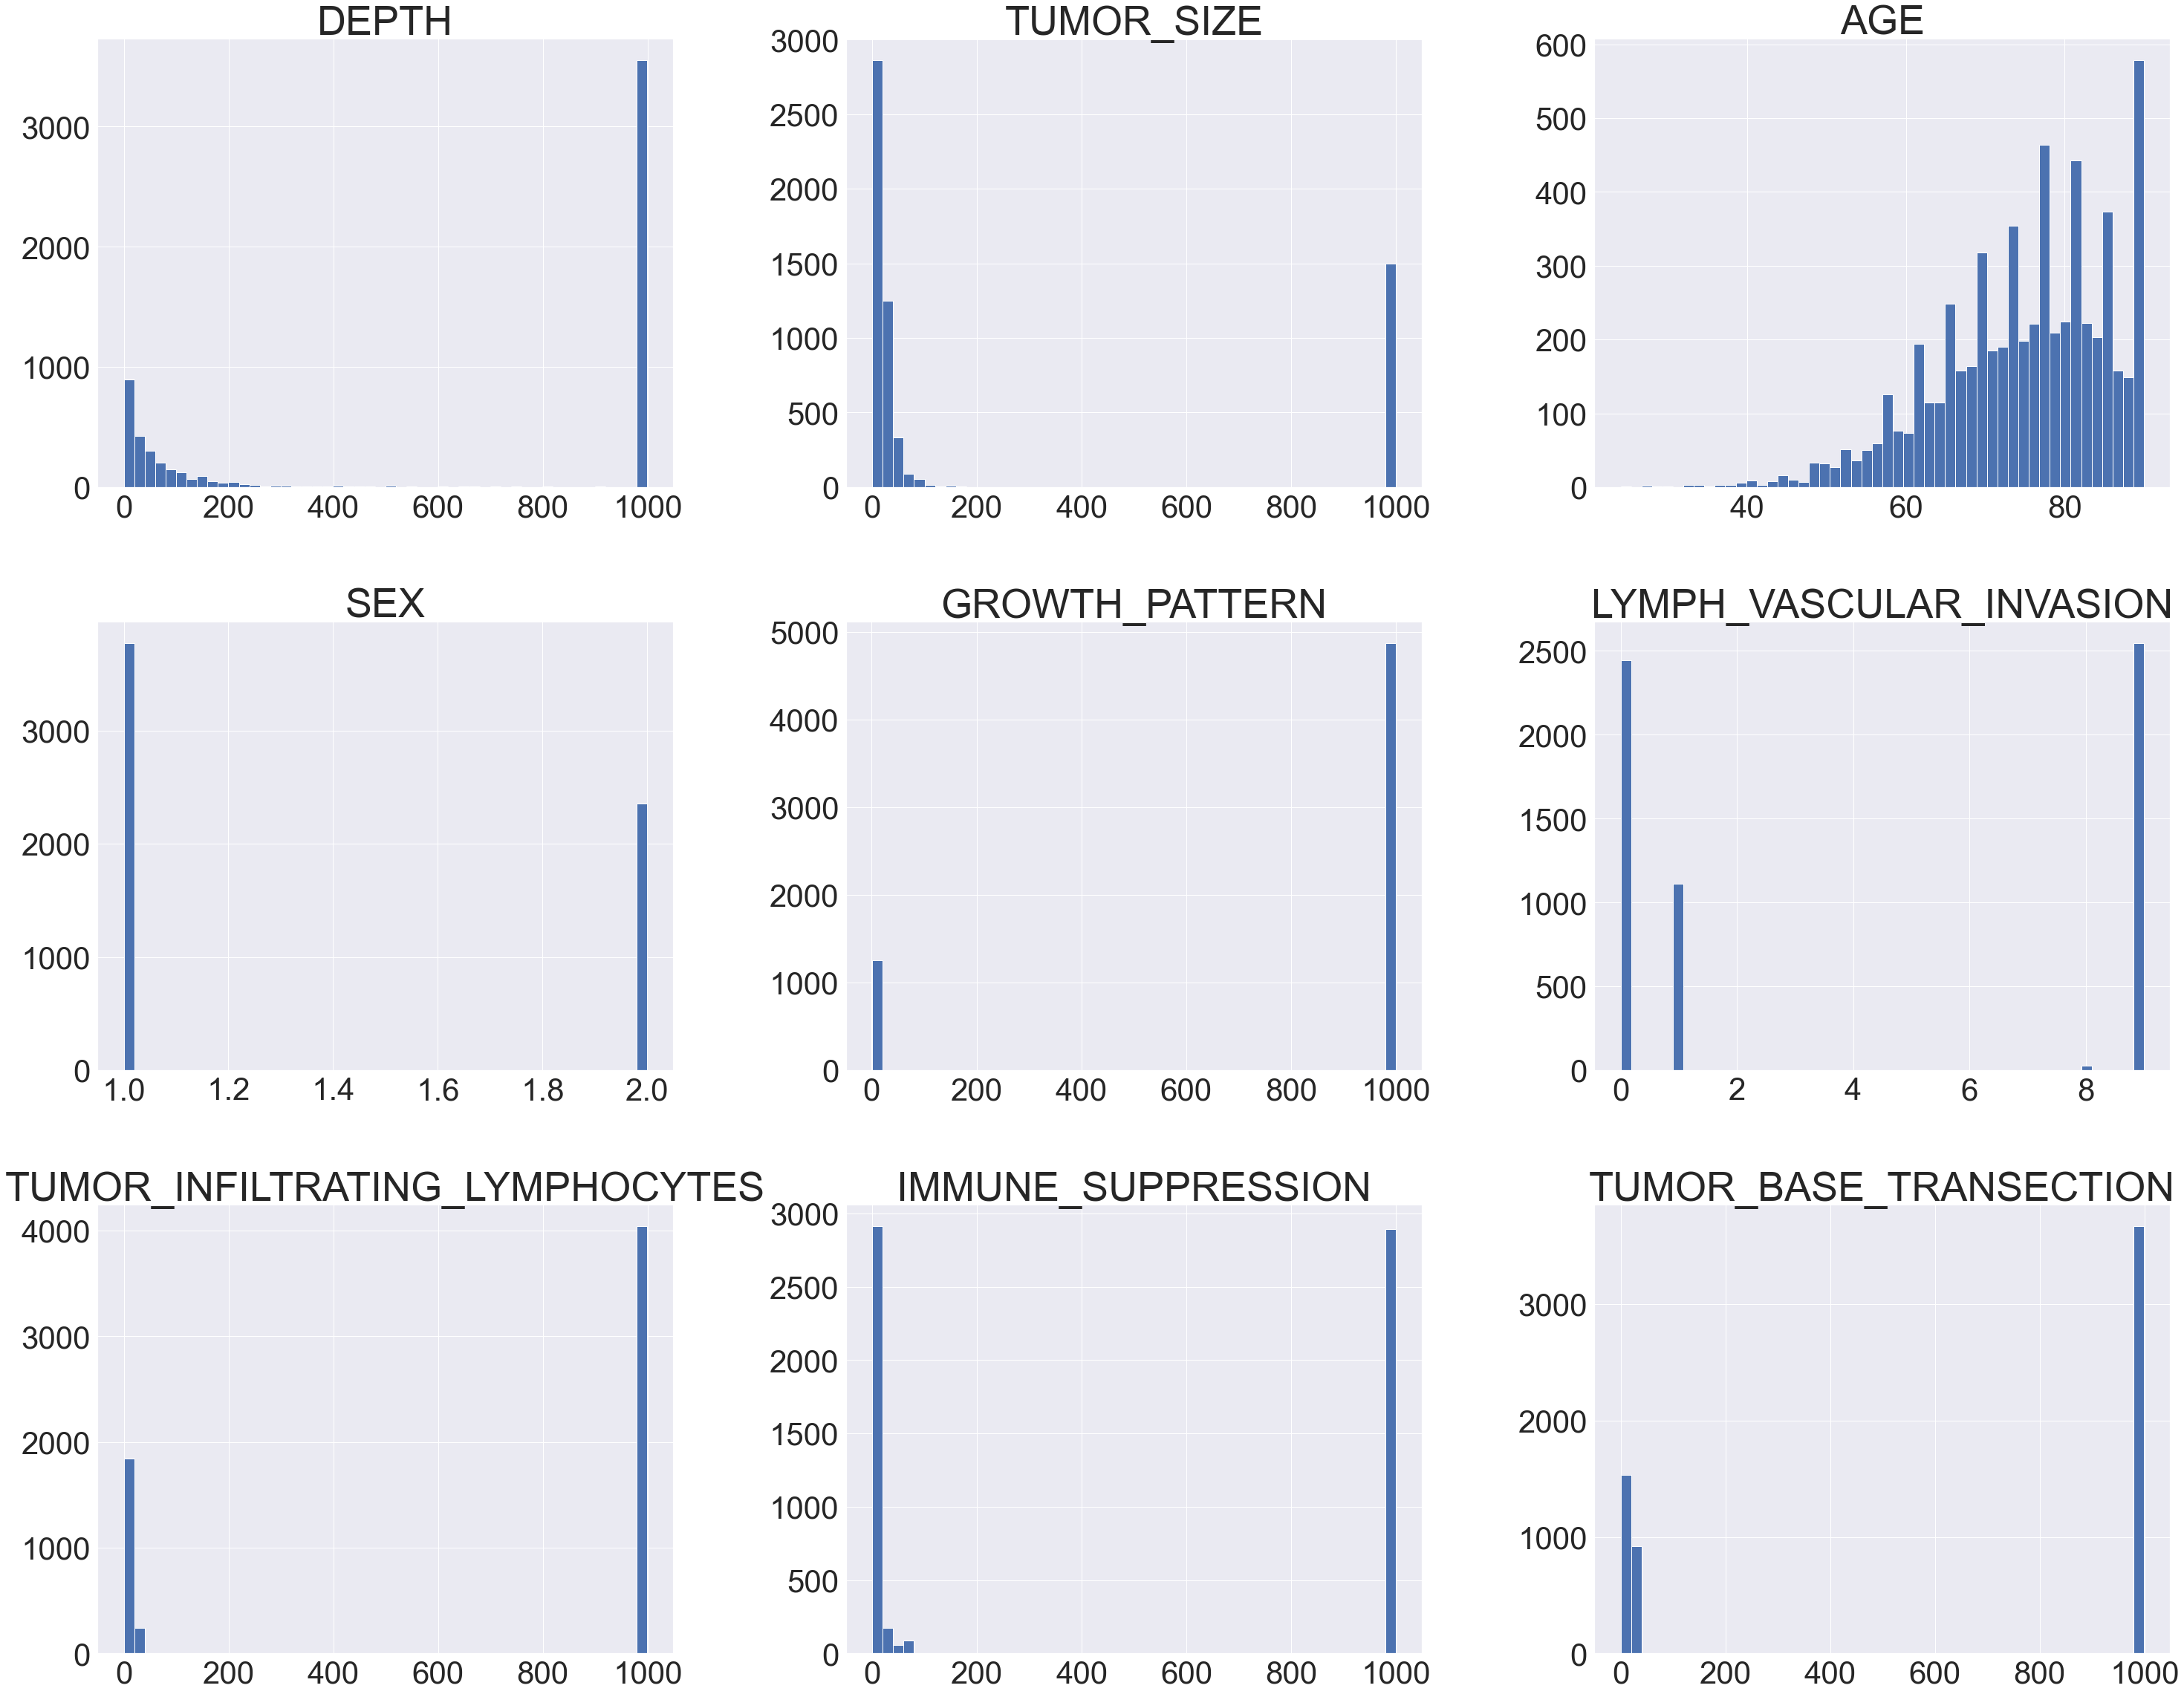

In [82]:
params = {'axes.titlesize':'54',
          'xtick.labelsize':'42',
          'ytick.labelsize':'42'}
matplotlib.rcParams.update(params)
mcc_seer.drop(['PRIMARY_SITE', 'HISTOLOGY', 'LATERALITY', 'YEAR_OF_DIAGNOSIS', 'SLNB'],axis=1).hist(bins=50, figsize=(50,40))
plt.savefig(BASE_DIR+'../image/features_raw.pdf')

## Feature engineering

In [49]:
# convert YEAR_OF_DIAGNOSIS to YEAR_SINCE_DIAGNOSIS
mcc_seer['YEAR_SINCE_DIAGNOSIS'] = max(mcc_seer['YEAR_OF_DIAGNOSIS']) - mcc_seer['YEAR_OF_DIAGNOSIS']
mcc_seer.drop(['YEAR_OF_DIAGNOSIS'], axis=1, inplace=True)

In [50]:
# convert variables to objects
cat_vars = [
            'GROWTH_PATTERN','HISTOLOGY','LATERALITY','LYMPH_VASCULAR_INVASION',
            'TUMOR_INFILTRATING_LYMPHOCYTES', 'IMMUNE_SUPPRESSION', 'TUMOR_BASE_TRANSECTION'
           ]
mcc_seer[cat_vars] = mcc_seer[cat_vars].astype(object)

## Save cleaned data to csv and pickle

In [51]:
mcc_seer.to_csv(BASE_DIR+"../data/Merkel_seer_clean.csv")
mcc_seer.to_pickle(BASE_DIR+"../data/Merkel_seer_clean.pkl")

## Pairplot

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


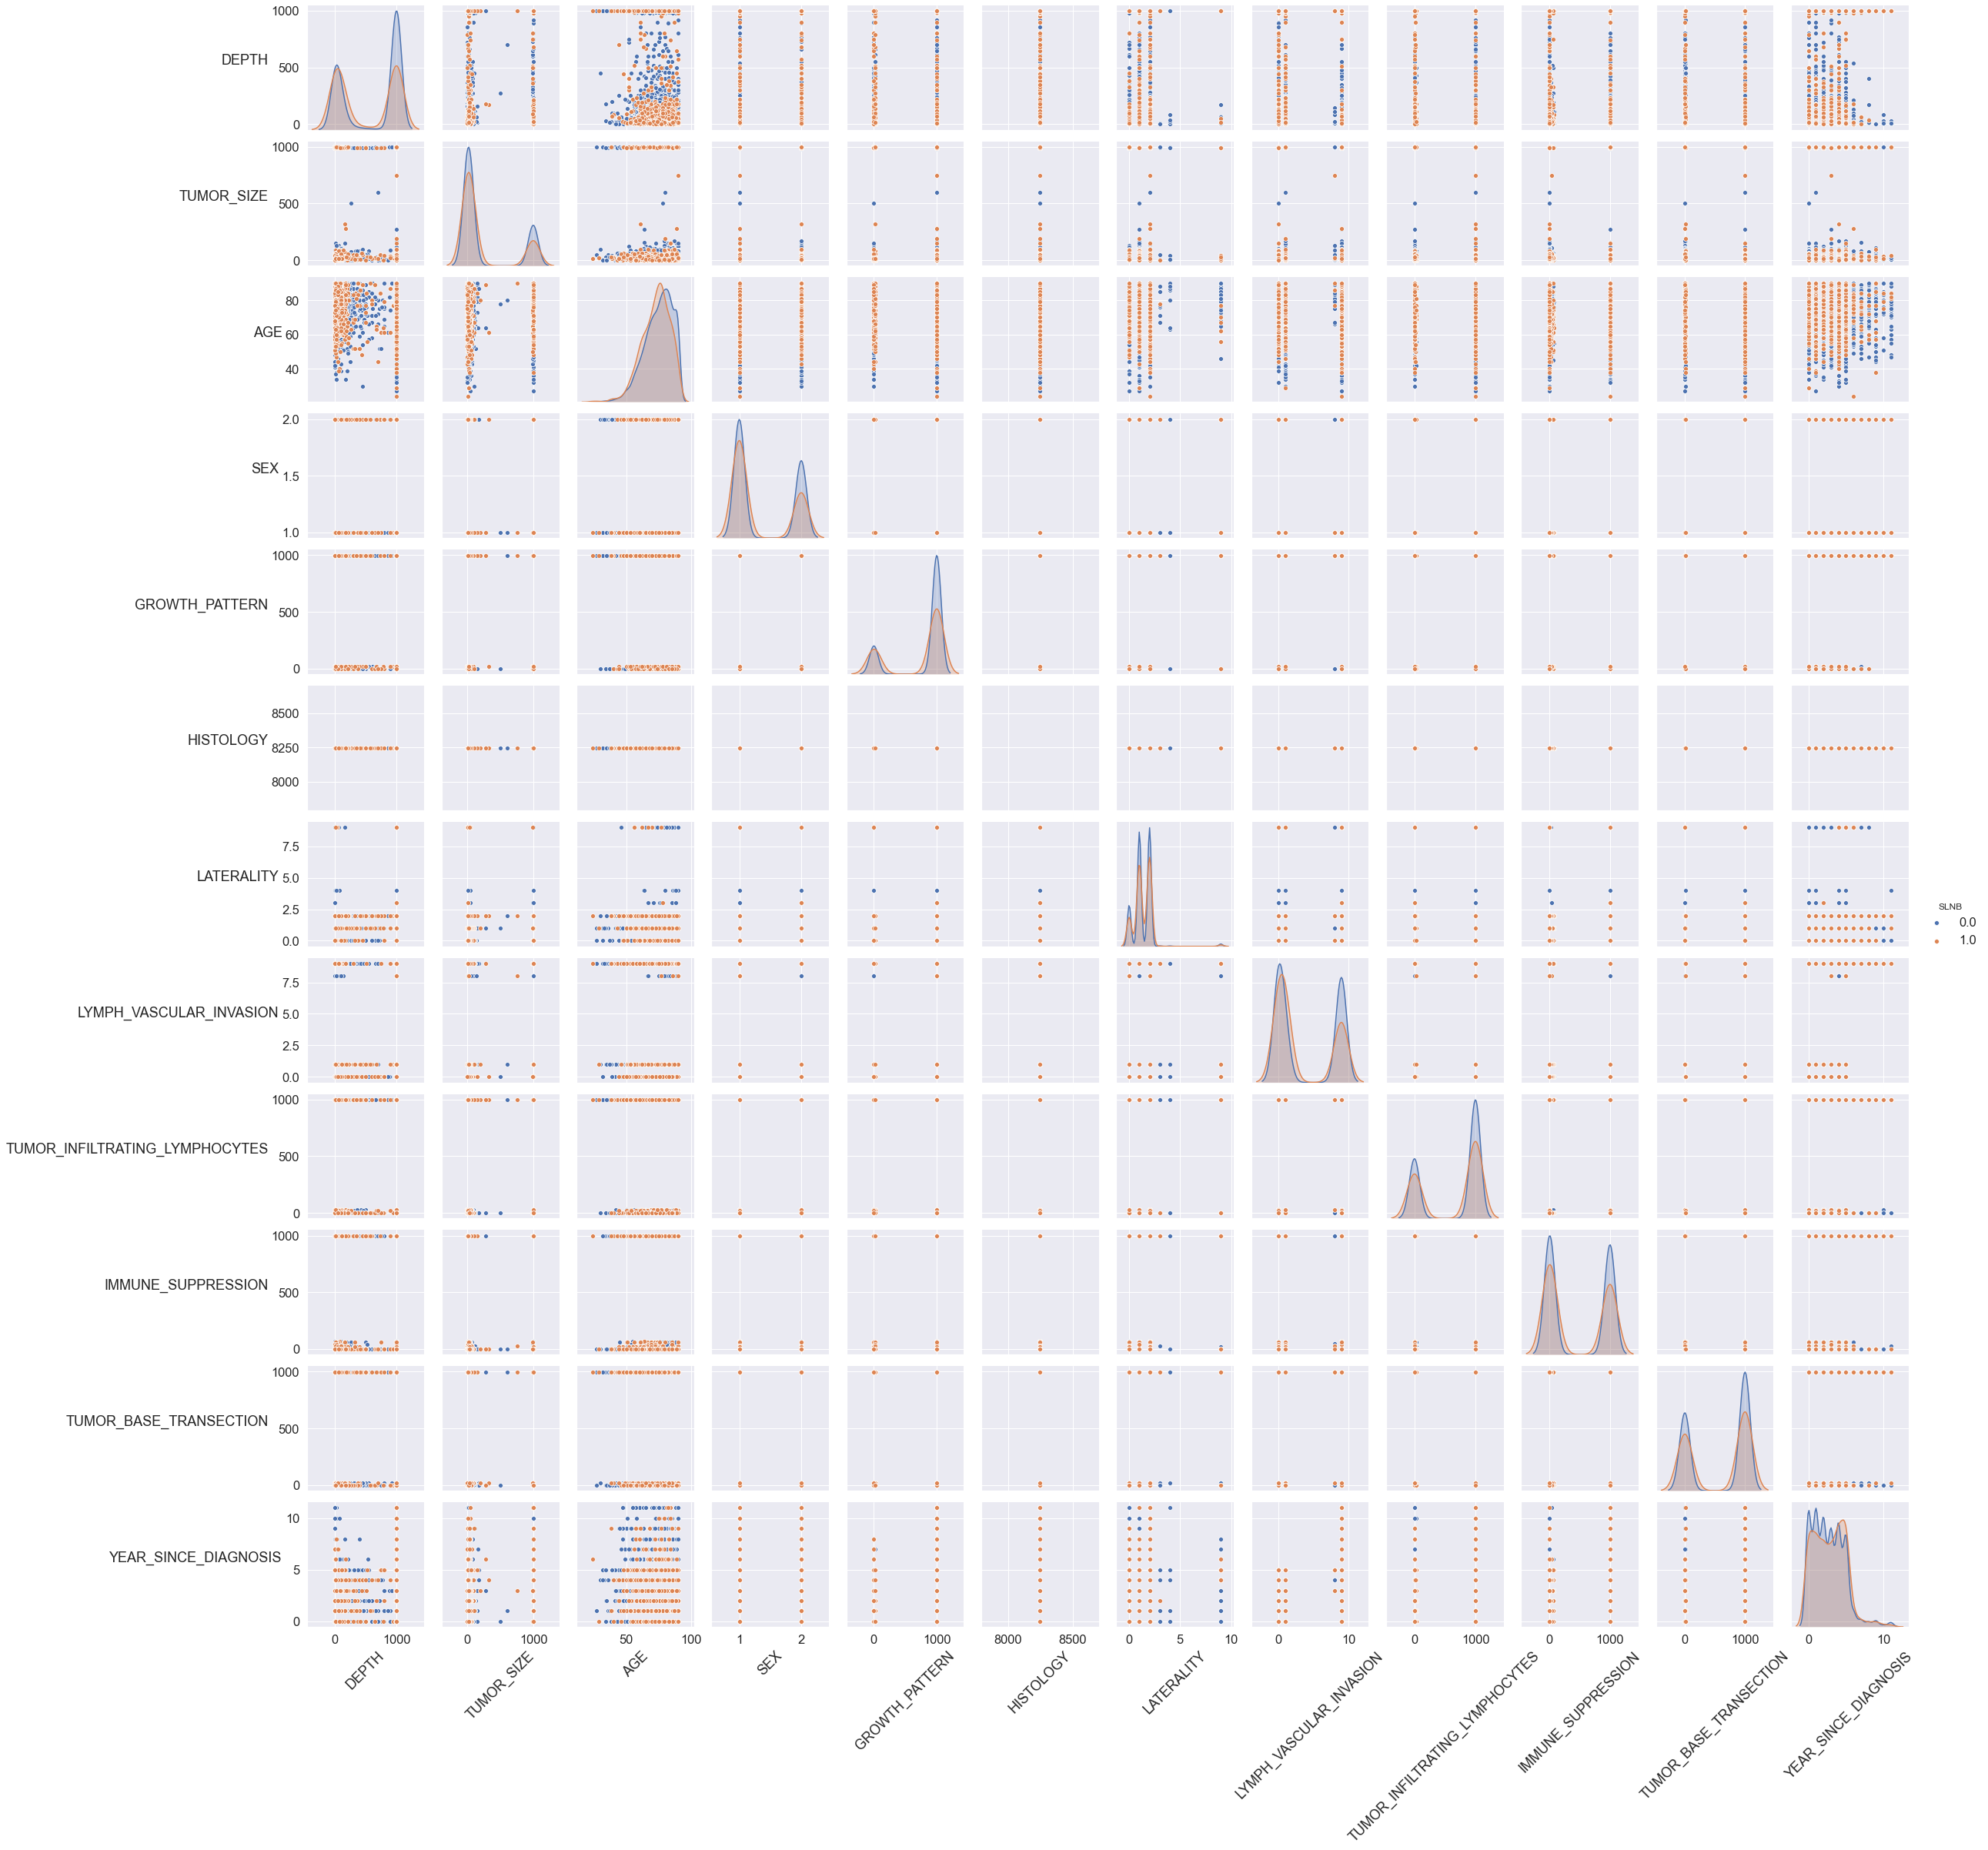

In [52]:
g = sns.pairplot(mcc_seer, hue = "SLNB")
# g.fig.draw(
#     g.fig.canvas.get_renderer()
# )  # required, as matplotlib calculates ticks during draw time
for ax in g.axes.flat: 
    ax.set_xlabel(ax.get_xlabel(), rotation=45)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')

## Relationship between label and features

### SLNB vs. depth

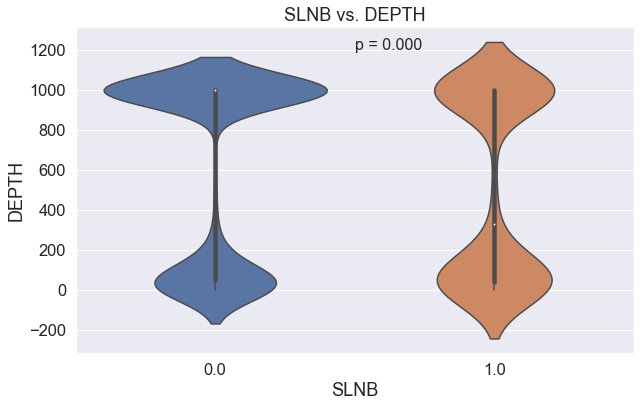

In [55]:
stat, pval = stats.mannwhitneyu(mcc_seer[mcc_seer['SLNB'] == 0]['DEPTH'],
                   mcc_seer[mcc_seer['SLNB'] == 1]['DEPTH'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='DEPTH', data=mcc_seer)
plt.text(0.5,1200,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. DEPTH')
plt.rcParams.update({'font.size': 16})
plt.show()

### SLNB vs. tumor_size

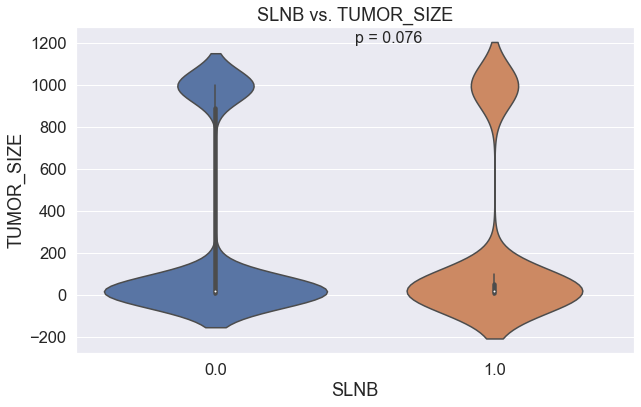

In [56]:
stat, pval = stats.mannwhitneyu(mcc_seer[mcc_seer['SLNB'] == 0]['TUMOR_SIZE'],
                   mcc_seer[mcc_seer['SLNB'] == 1]['TUMOR_SIZE'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='TUMOR_SIZE', data=mcc_seer)
plt.text(0.5,1200,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. TUMOR_SIZE')
plt.rcParams.update({'font.size': 16})
plt.show()

### SLNB vs. age

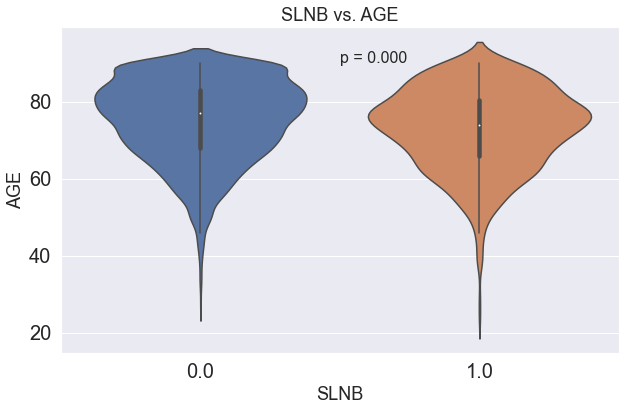

In [101]:
stat, pval = stats.mannwhitneyu(mcc_seer[mcc_seer['SLNB'] == 0]['AGE'],
                   mcc_seer[mcc_seer['SLNB'] == 1]['AGE'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='AGE', data=mcc_seer)
plt.text(0.5,90,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. AGE')
plt.rcParams.update({'font.size': 16})
plt.savefig(BASE_DIR+'../image/SLNBvsAGE.pdf')

### SLNB vs. YEAR_SINCE_DIAGNOSIS

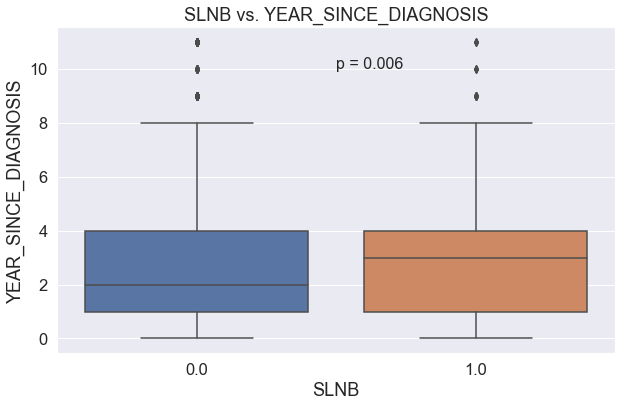

In [58]:
stat, pval = stats.mannwhitneyu(mcc_seer[mcc_seer['SLNB'] == 0]['YEAR_SINCE_DIAGNOSIS'],
                   mcc_seer[mcc_seer['SLNB'] == 1]['YEAR_SINCE_DIAGNOSIS'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.boxplot(x='SLNB', y='YEAR_SINCE_DIAGNOSIS', data=mcc_seer)
plt.text(0.5,10,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. YEAR_SINCE_DIAGNOSIS')
plt.show()

### SLNB vs. sex

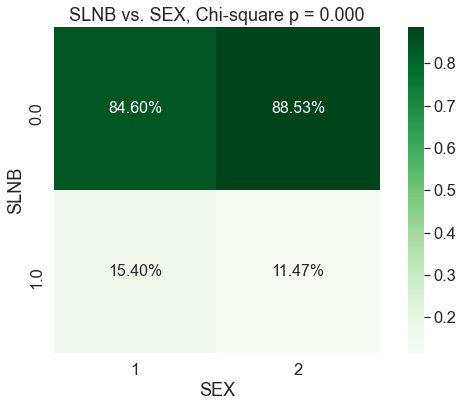

In [59]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['SEX'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. SEX, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. growth_pattern

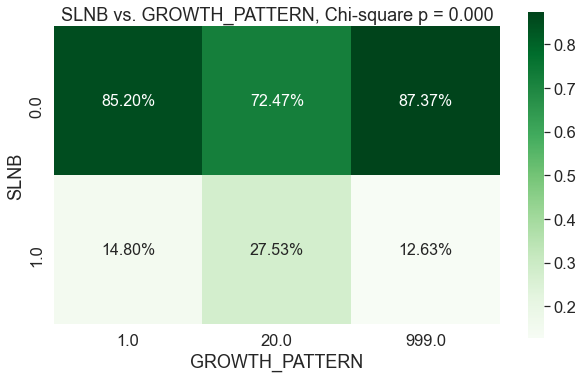

In [60]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['GROWTH_PATTERN'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. GROWTH_PATTERN, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. histology (deprecated)

In [61]:
# plot_data = pd.crosstab(mcc_seer['HISTOLOGY'],mcc_seer['SLNB'])
# chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
# plot_data = plot_data/plot_data.sum(axis=0)
# plt.figure(figsize=(10,30))
# sns.heatmap(plot_data, 
#             annot=True, 
#             cmap='Greens',
#             square=True,
#             fmt = '.2%').set_title('SLNB vs. HISTOLOGY, Chi-square p = {:.3f}'.format(pval))
# # plt.text(0.5,25,'p = {:.3f}'.format(pval))
# plt.show()

### SLNB vs. laterality (deprecated)

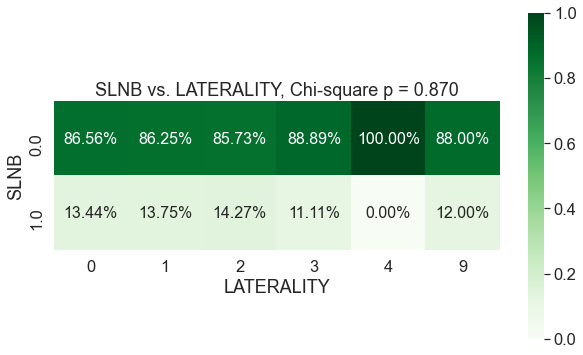

In [62]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['LATERALITY'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. LATERALITY, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. lymph_vascular_invasion

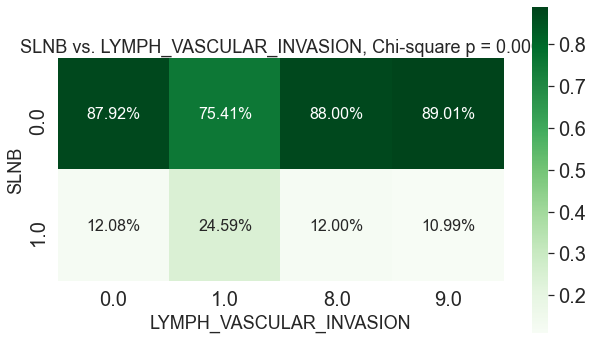

In [100]:
params = {'axes.titlesize':'18',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['LYMPH_VASCULAR_INVASION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. LYMPH_VASCULAR_INVASION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.savefig(BASE_DIR+'../image/SLNBvsLVI.pdf')

### SLNB vs. TUMOR_INFILTRATING_LYMPHOCYTES

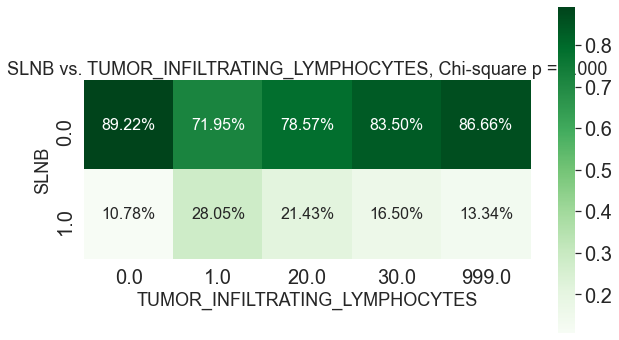

In [102]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['TUMOR_INFILTRATING_LYMPHOCYTES'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(10,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. TUMOR_INFILTRATING_LYMPHOCYTES, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.savefig(BASE_DIR+'../image/SLNBvsTIL.pdf')

### SLNB vs. IMMUNE_SUPPRESSION

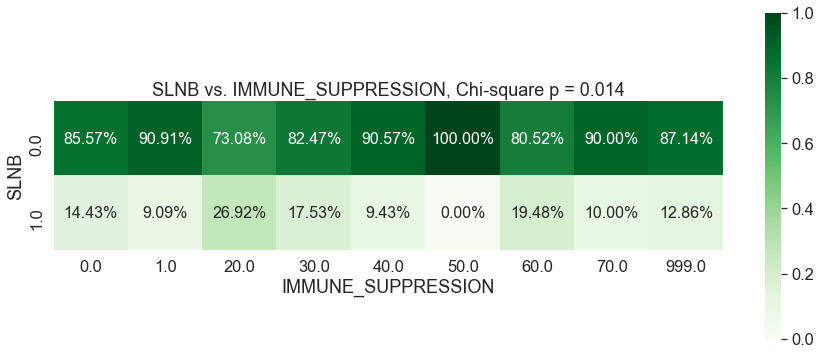

In [65]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['IMMUNE_SUPPRESSION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(15,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. IMMUNE_SUPPRESSION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

### SLNB vs. TUMOR_BASE_TRANSECTION

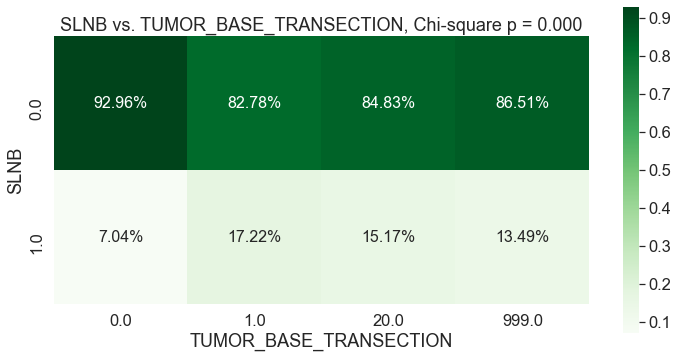

In [67]:
plot_data = pd.crosstab(mcc_seer['SLNB'],mcc_seer['TUMOR_BASE_TRANSECTION'])
chi2, pval, dof, ex = stats.chi2_contingency(plot_data.to_numpy(), correction=False)
plot_data = plot_data/plot_data.sum(axis=0)
plt.figure(figsize=(12,6))
sns.heatmap(plot_data, 
            annot=True, 
            cmap='Greens',
            square=True,
            fmt = '.2%').set_title('SLNB vs. TUMOR_BASE_TRANSECTION, Chi-square p = {:.3f}'.format(pval))
# plt.text(0.5,25,'p = {:.3f}'.format(pval))
plt.show()

In [68]:
mcc_seer['AGE'].describe()

count    6125.000000
mean       74.844082
std        10.736483
min        24.000000
25%        68.000000
50%        76.000000
75%        83.000000
max        90.000000
Name: AGE, dtype: float64

## After imputing DEPTH and TUMOR_SIZE

In [70]:
mcc_seer_sel = pd.read_pickle(BASE_DIR + '../data/Merkel_seer_clean_selectedVars_encoded_imputed.pkl')

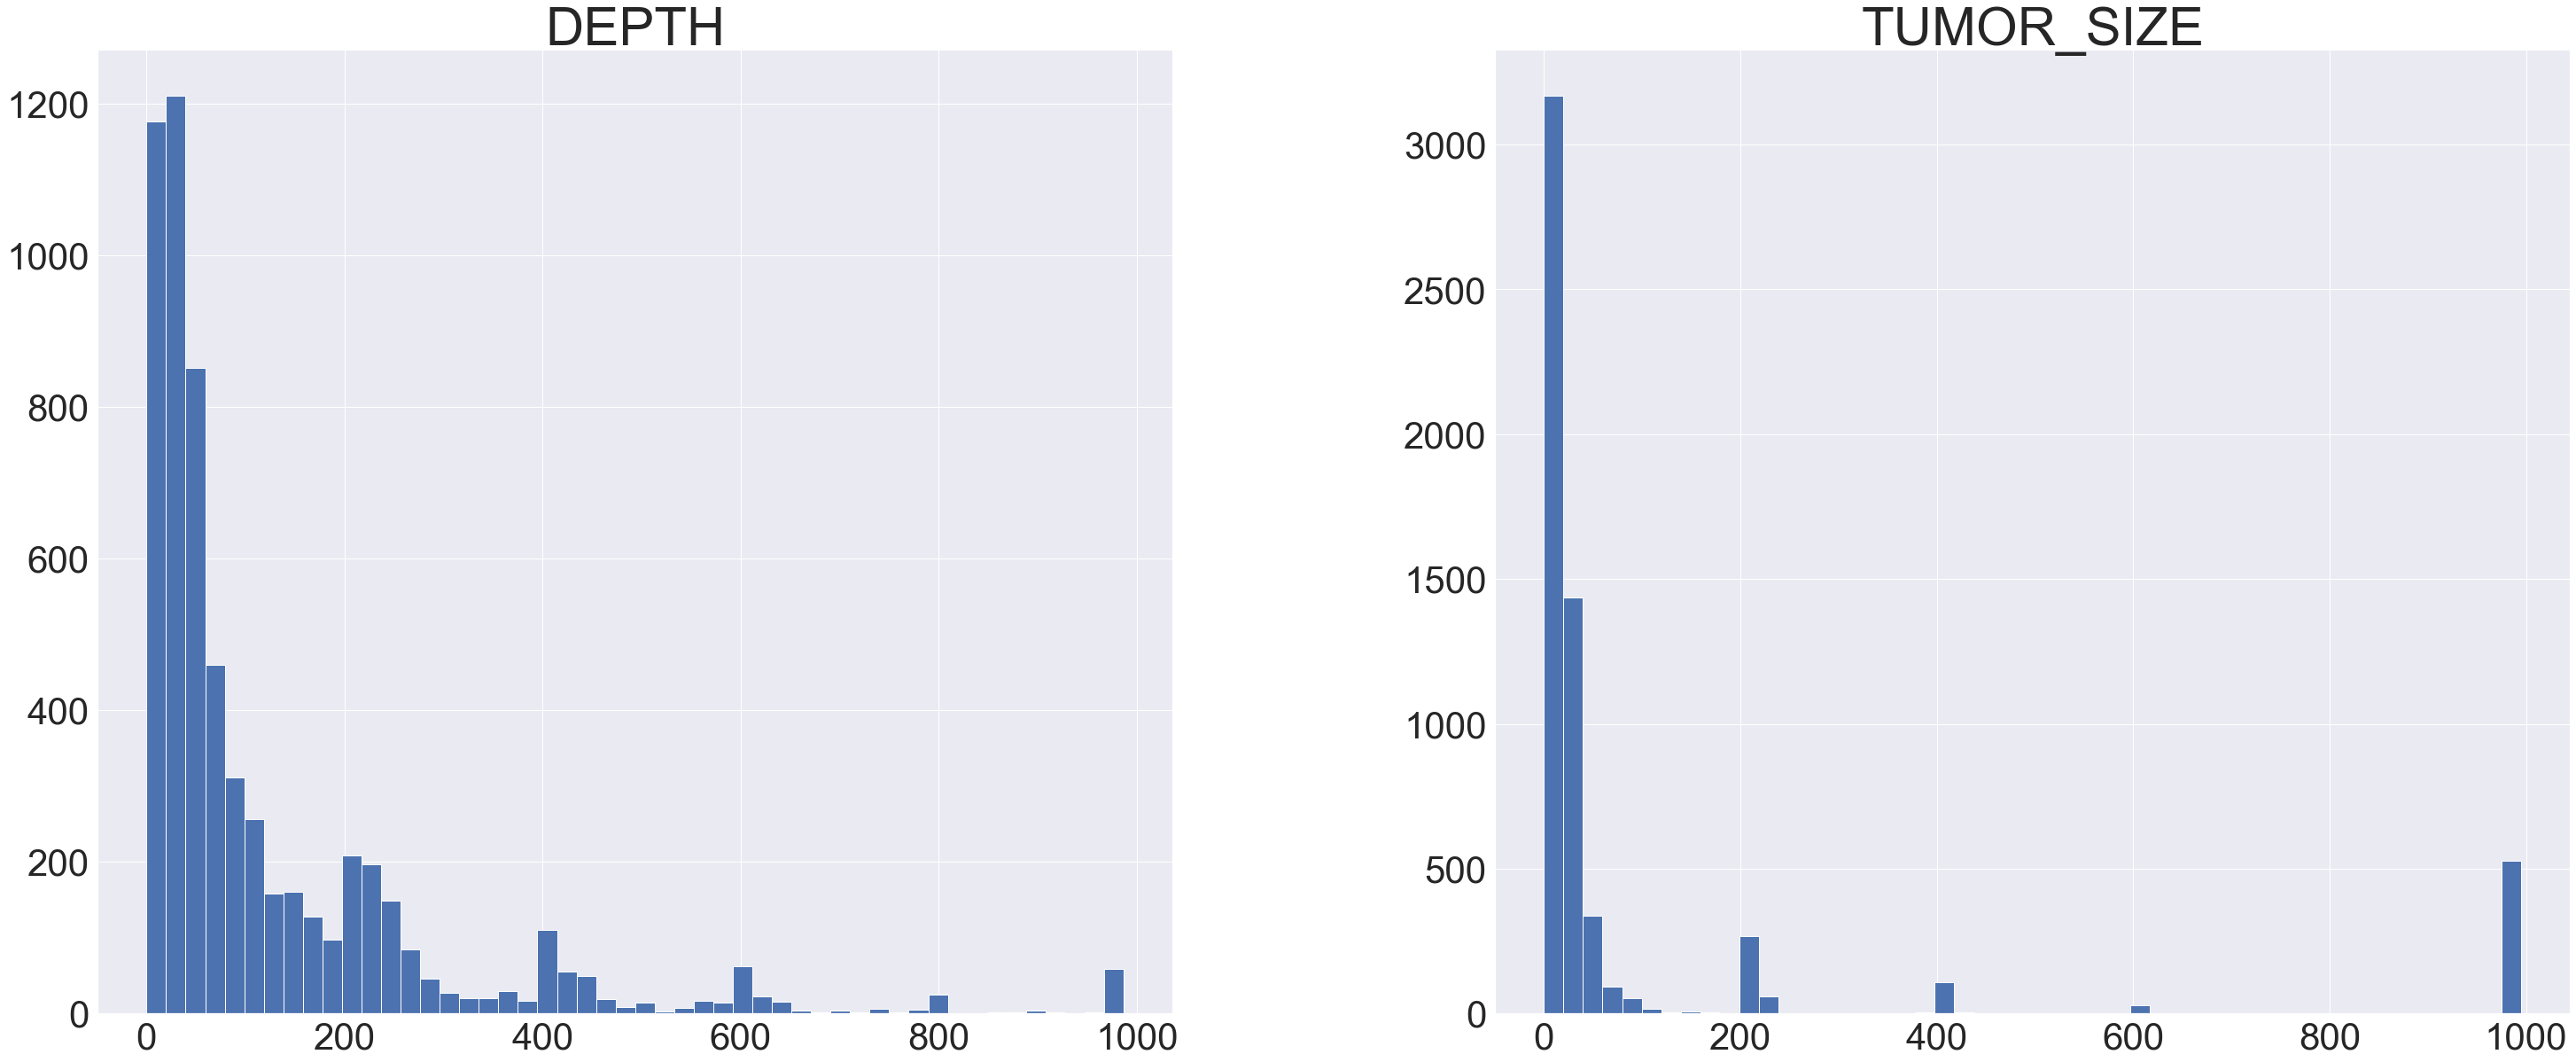

In [86]:
# check distribution
params = {'axes.titlesize':'60',
          'xtick.labelsize':'42',
          'ytick.labelsize':'42'}
matplotlib.rcParams.update(params)
mcc_seer_sel[['DEPTH','TUMOR_SIZE']].hist(bins=50, figsize=(50,20))
plt.savefig(BASE_DIR+'../image/depth_tumor_size_imputed.pdf')

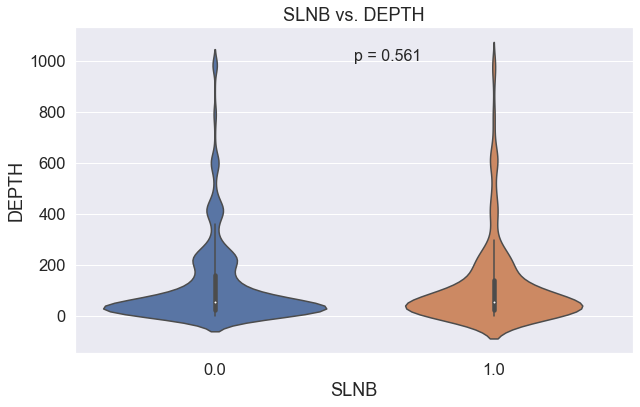

In [65]:
stat, pval = stats.mannwhitneyu(mcc_seer_sel[mcc_seer_sel['SLNB'] == 0]['DEPTH'],
                   mcc_seer_sel[mcc_seer_sel['SLNB'] == 1]['DEPTH'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='DEPTH', data=mcc_seer_sel)
plt.text(0.5,1000,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. DEPTH')
plt.rcParams.update({'font.size': 16})
plt.show()

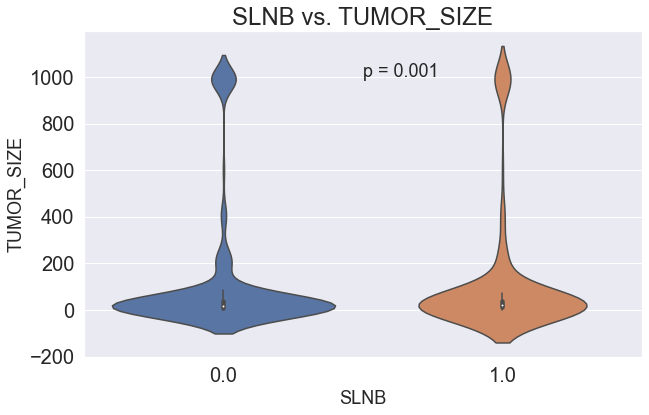

In [98]:
stat, pval = stats.mannwhitneyu(mcc_seer_sel[mcc_seer_sel['SLNB'] == 0]['TUMOR_SIZE'],
                   mcc_seer_sel[mcc_seer_sel['SLNB'] == 1]['TUMOR_SIZE'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='TUMOR_SIZE', data=mcc_seer_sel)
plt.text(0.5,1000,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. TUMOR_SIZE')
plt.rcParams.update({'font.size': 16})
plt.savefig(BASE_DIR+'../image/SLNBvsTUMORSIZE.pdf')

In [ ]:


stat, pval = stats.mannwhitneyu(mcc_seer_sel[mcc_seer_sel['SLNB'] == 0]['DEPTH'],
                   mcc_seer_sel[mcc_seer_sel['SLNB'] == 1]['DEPTH'],
                   alternative = 'two-sided')
plt.figure(figsize=(10,6))
sns.violinplot(x='SLNB', y='DEPTH', data=mcc_seer_sel)
plt.text(0.5,1000,'p = {:.3f}'.format(pval))
plt.title('SLNB vs. DEPTH')
plt.rcParams.update({'font.size': 16})
plt.show()

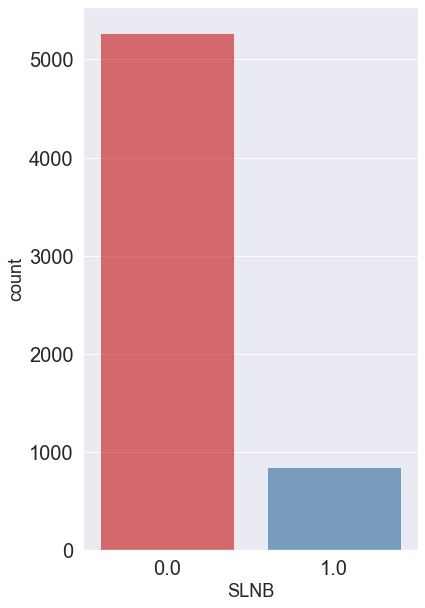

In [97]:
params = {'axes.titlesize':'24',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)
plt.figure(figsize = (6, 10))
ax = sns.countplot(x="SLNB", data=mcc_seer_sel, palette="Set1", alpha=.7)
plt.savefig(BASE_DIR+'../image/label.pdf')

## Ideas to note:

- CoxPH
- LASSO-Cox
- Random Survival Forest